# 0. Prerequisities

In [44]:
import yfinance as yf
import numpy as np
import pandas as pd
import random

In [45]:
tickerlist = [
    "AAPL", # Apple
    "PFE", # Pfizer
    "XOM", # ExxonMobil
    "JPM", # JPMorgan
    "GE", # General Electric
    "ED", # Consolidated Edison
    "O", # Realty Income
    "DD", # Dupont
    "NFLX", # Netflix
    "KO", # Coca Cola
    "TSLA", # Tesla
    "AMZN", # Amazon
    "^GSPC" # S&P 500
]

In [46]:
# Actual Start Date is 2019-01-01, here we get data to calculate monthly change rate
monthly_startdate = "2018-12-01"

# Actual Start Date is 2019-01-01, here we get data to calculate monthly change rate
daily_startdate = "2018-12-31"

# We assume the end date of data is Nov 31st, 2024
enddate = "2024-12-01"

In [ ]:
# Set Random Seed
random.seed(42)

# 1. Get Daily and Monthly Data

In [48]:
dailydf = pd.DataFrame()
monthlydf = pd.DataFrame()

for code in tickerlist:
    ticker = yf.Ticker(code)
    code = code if code != "^GSPC" else "SP500"
    daily = ticker.history(start=daily_startdate, end=enddate)
    daily["Daily_Change"] = daily["Close"] / daily["Close"].shift(1) - 1
    daily = daily[1:]
    daily.to_csv(f"./Daily/{code}.csv")
    daily = daily[["Daily_Change"]].rename(columns={"Daily_Change": code})
    if dailydf.empty:
        dailydf = daily
    else:
        dailydf = pd.merge(dailydf, daily, on="Date")

    monthly = ticker.history(start=monthly_startdate, end=enddate, interval="1mo")
    monthly["Monthly_Change"] = monthly["Close"] / monthly["Close"].shift(1) - 1
    monthly = monthly[1:]
    monthly.to_csv(f"./Monthly/{code}.csv")
    monthly = monthly[["Monthly_Change"]].rename(columns={"Monthly_Change": code})
    if monthlydf.empty:
        monthlydf = monthly
    else:
        monthlydf = pd.merge(monthlydf, monthly, on="Date")

dailydf.to_csv("Daily.csv")
monthlydf.to_csv("Monthly.csv")

In [49]:
monthly_risk_free_rate = 0.18e-2
daily_risk_free_rate = monthly_risk_free_rate / 21

# 2. Project Structure

## 2.1 Executive Summary

## 2.2 Descriptive Statistics

In [50]:
daily = pd.read_csv("Daily.csv", index_col=0)
monthly = pd.read_csv("Monthly.csv", index_col=0)

### 2.2.1 Mean, Standard Deviation, Skewness, Kurtosis and Beta

In [51]:
# Description of Daily Data
from scipy.stats import skew, kurtosis

daily_describe = pd.DataFrame()
daily_describe["Mean"] = daily.mean()
daily_describe["Std"] = daily.std()
daily_describe["Skewness"] = daily.apply(skew)
daily_describe["Kurtosis"] = daily.apply(kurtosis)
market_return = daily["SP500"]
cov_matrix = daily.cov()
market_variance = market_return.var()
daily_describe["Beta"] = cov_matrix["SP500"] / market_variance
daily_describe

Mean       Std  Skewness   Kurtosis      Beta
AAPL   0.001427  0.019521 -0.006442   5.437596  1.202120
PFE   -0.000003  0.016535  0.292839   4.206269  0.555927
XOM    0.000771  0.020421  0.049579   5.117671  0.842562
JPM    0.000936  0.019392  0.435506  13.804111  1.079608
GE     0.001415  0.025075  0.087399   5.146480  1.155766
ED     0.000439  0.014680  0.347006  24.156073  0.486955
O      0.000324  0.018575 -2.252857  44.795135  0.835980
DD     0.000374  0.021587  0.190534   9.095247  1.093394
NFLX   0.001203  0.027779 -1.181515  22.581795  1.047649
KO     0.000410  0.012773 -0.729132   9.429762  0.611643
TSLA   0.002667  0.040640  0.209187   3.558334  1.551135
AMZN   0.000916  0.021557  0.071226   4.324683  1.094286
SP500  0.000671  0.012724 -0.543254  14.044824  1.000000

In [52]:
# Mean and Standard Deviation of Monthly Data
monthly_describe = pd.DataFrame()
monthly_describe["Mean"] = monthly.mean()
monthly_describe["Std"] = monthly.std()
monthly_describe["Skewness"] = monthly.apply(skew)
monthly_describe["Kurtosis"] = monthly.apply(kurtosis)
market_return = monthly["SP500"]
cov_matrix = monthly.cov()
market_variance = market_return.var()
monthly_describe["Beta"] = cov_matrix["SP500"] / market_variance
monthly_describe

Mean       Std  Skewness  Kurtosis      Beta
AAPL   0.029534  0.082417 -0.090392 -0.805743  1.252990
PFE   -0.000448  0.074742  0.709166  0.428623  0.577038
XOM    0.015945  0.092921  0.199641  0.895715  0.900963
JPM    0.018846  0.078245 -0.219652  0.690280  1.124922
GE     0.029775  0.115565  0.246307  1.079156  1.319405
ED     0.008347  0.055171 -0.084771  0.621480  0.313683
O      0.005558  0.069036 -1.295353  4.557197  0.909213
DD     0.007943  0.101788  0.355527  1.641830  1.364858
NFLX   0.024674  0.117601 -1.077809  4.417295  1.333543
KO     0.008229  0.053228 -0.745961  1.106956  0.572743
TSLA   0.059527  0.214034  0.775251  0.419997  2.260984
AMZN   0.018401  0.090811  0.363242  0.825374  1.177116
SP500  0.013702  0.050379 -0.481178  0.054048  1.000000

### 2.2.2 Equity Curve Plot

In [53]:
# Plot of Equity Curve of Daily Data
import plotly.graph_objects as go

fig = go.Figure()

for code in tickerlist:
    code = code if code != "^GSPC" else "SP500"
    tickerdf = pd.read_csv(f"./Daily/{code}.csv")
    fig.add_trace(
        go.Scatter(
            x = tickerdf["Date"],
            y = tickerdf["Close"] / tickerdf["Close"].loc[0],
            name = code
        )
    )

fig.update_layout(
    title = "Equity Curve",
    xaxis = dict(title="Date"),
    yaxis = dict(title="Close Price")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [54]:
# Plot of Equity Curve of Monthly Data
fig = go.Figure()

for code in tickerlist:
    code = code if code != "^GSPC" else "SP500"
    tickerdf = pd.read_csv(f"./Monthly/{code}.csv")
    fig.add_trace(
        go.Scatter(
            x = tickerdf["Date"],
            y = tickerdf["Close"] / tickerdf["Close"].loc[0],
            name = code
        )
    )

fig.update_layout(
    title = "Equity Curve",
    xaxis = dict(title="Date"),
    yaxis = dict(title="Close Price")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

### 2.2.3 Stationary Test and Normality Test

In [55]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [56]:
SP500_daily = daily["SP500"]
SP500_monthly = monthly["SP500"]
daily = daily.drop(columns=["SP500"], axis=1)
monthly = monthly.drop(columns=["SP500"], axis=1)

#### (1) Stationary Test (ADF Test)

Stationarity (ADF Test):

- ADF Statistic: A negative number. The more negative it is, the stronger the evidence against the null hypothesis (which states that the series is non-stationary).

- p-value: If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the series is stationary.

- Critical Values: If the ADF statistic is less than the critical values, we reject the null hypothesis of non-stationarity.

In [57]:
# Daily Data
adf_result = pd.DataFrame(columns=[["ADF Statistic", "P-value", "Critical Value 1%", "Critical Value 5%", "Critical Value 10%"]])

for column in daily.columns:
    adf = adfuller(daily[column])
    adf_result.loc[column, "ADF Statistic"] = adf[0]
    adf_result.loc[column, "P-value"] = adf[1]
    for key, value in adf[4].items():
        adf_result.loc[column, f"Critical Value {key}"] = value
adf_result

ADF Statistic P-value Critical Value 1% Critical Value 5%  \
AAPL    -12.234884     0.0         -3.434776         -2.863495   
PFE      -8.676309     0.0         -3.434825         -2.863516   
XOM     -13.710878     0.0         -3.434773         -2.863494   
JPM      -11.27278     0.0         -3.434788           -2.8635   
GE      -10.363436     0.0         -3.434788           -2.8635   
ED      -12.596648     0.0         -3.434788           -2.8635   
O        -9.560895     0.0         -3.434803         -2.863507   
DD       -13.71749     0.0          -3.43477         -2.863492   
NFLX    -12.740598     0.0         -3.434776         -2.863495   
KO      -11.818607     0.0         -3.434785         -2.863499   
TSLA    -11.450042     0.0         -3.434776         -2.863495   
AMZN    -39.703319     0.0         -3.434752         -2.863484   

     Critical Value 10%  
AAPL          -2.567811  
PFE           -2.567822  
XOM            -2.56781  
JPM           -2.567814  
GE            -2.567814  
ED            -2.567814  
O             -2.567817  
DD            -2.567809  
NFLX          -2.567811  
KO            -2.567813  
TSLA          -2.567811  
AMZN          -2.567805

In [58]:
# Monthly Data
adf_result = pd.DataFrame(columns=[["ADF Statistic", "P-value", "Critical Value 1%", "Critical Value 5%", "Critical Value 10%"]])

for column in monthly.columns:
    adf = adfuller(monthly[column])
    adf_result.loc[column, "ADF Statistic"] = adf[0]
    adf_result.loc[column, "P-value"] = adf[1]
    for key, value in adf[4].items():
        adf_result.loc[column, f"Critical Value {key}"] = value
adf_result

ADF Statistic   P-value Critical Value 1% Critical Value 5%  \
AAPL     -7.092724       0.0          -3.52889          -2.90444   
PFE      -7.795078       0.0          -3.52889          -2.90444   
XOM      -8.422577       0.0         -3.527426         -2.903811   
JPM      -8.387172       0.0         -3.527426         -2.903811   
GE       -7.684612       0.0         -3.527426         -2.903811   
ED       -7.873794       0.0          -3.52889          -2.90444   
O        -7.626969       0.0          -3.52889          -2.90444   
DD       -9.331574       0.0         -3.527426         -2.903811   
NFLX     -4.619715  0.000119          -3.52889          -2.90444   
KO       -8.384355       0.0          -3.52889          -2.90444   
TSLA     -7.814458       0.0         -3.527426         -2.903811   
AMZN     -9.545133       0.0         -3.527426         -2.903811   

     Critical Value 10%  
AAPL          -2.589656  
PFE           -2.589656  
XOM            -2.58932  
JPM            -2.58932  
GE             -2.58932  
ED            -2.589656  
O             -2.589656  
DD             -2.58932  
NFLX          -2.589656  
KO            -2.589656  
TSLA           -2.58932  
AMZN           -2.58932

#### (2) Histogram Plots and Q-Q Plots for Normality Test

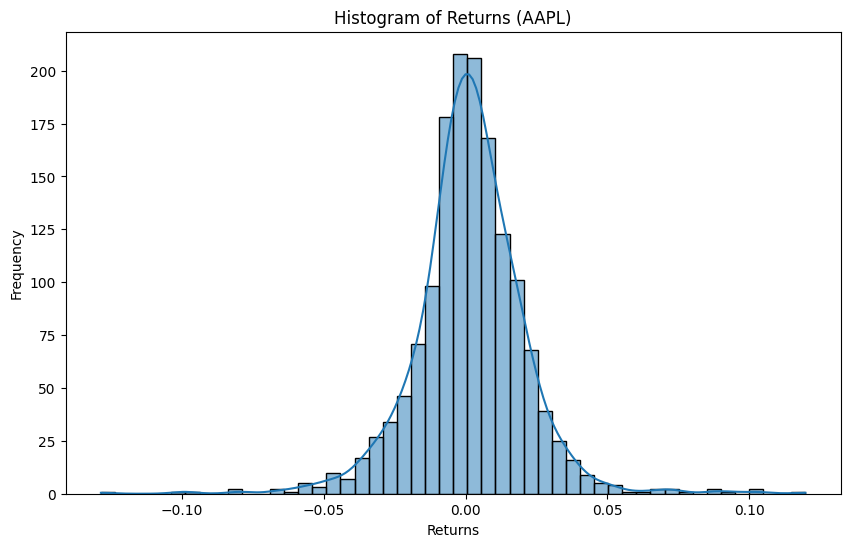

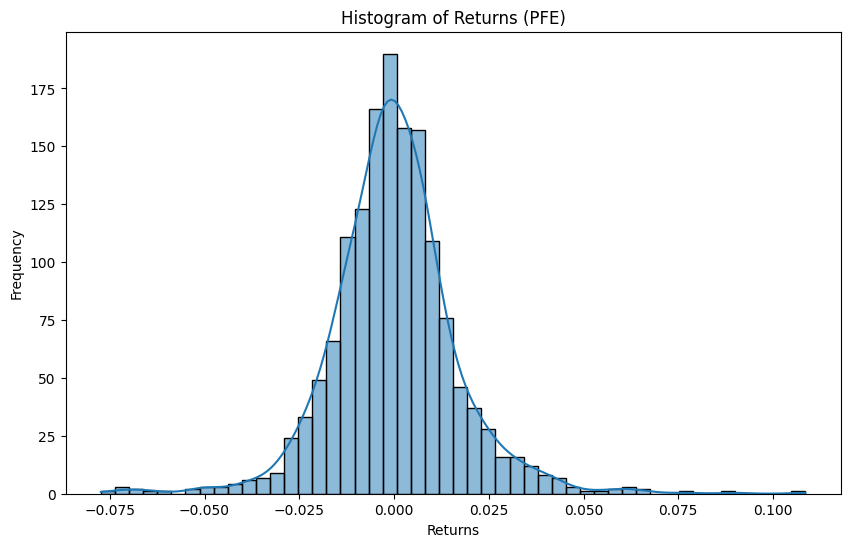

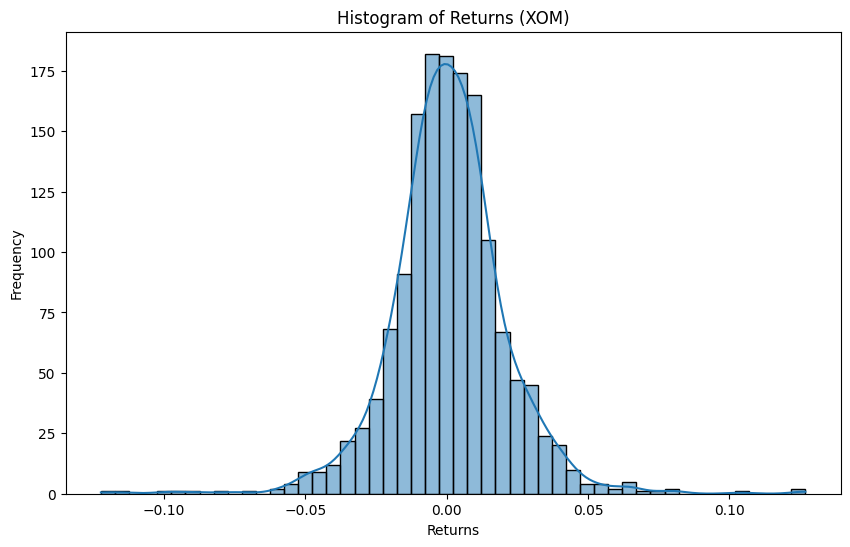

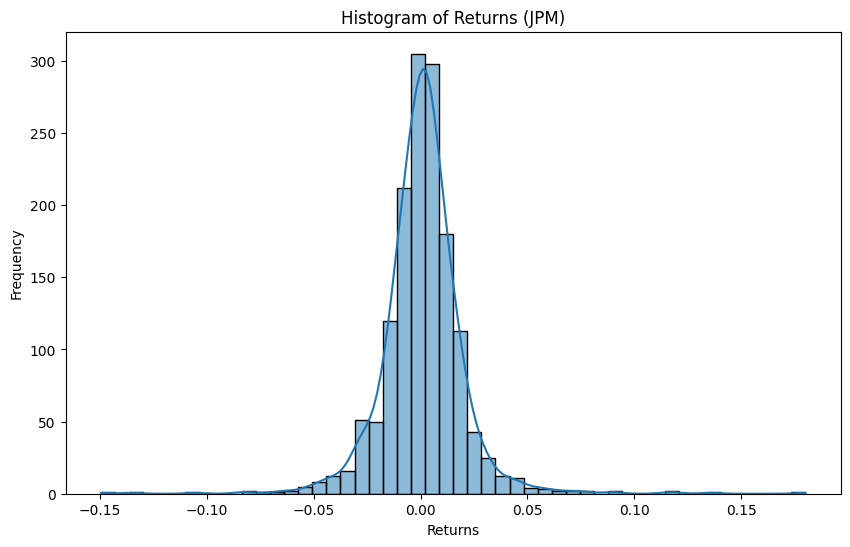

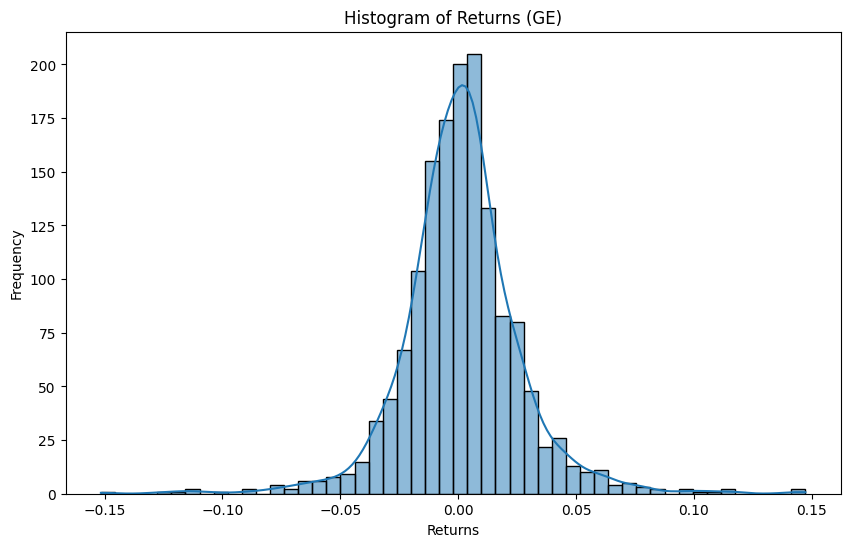

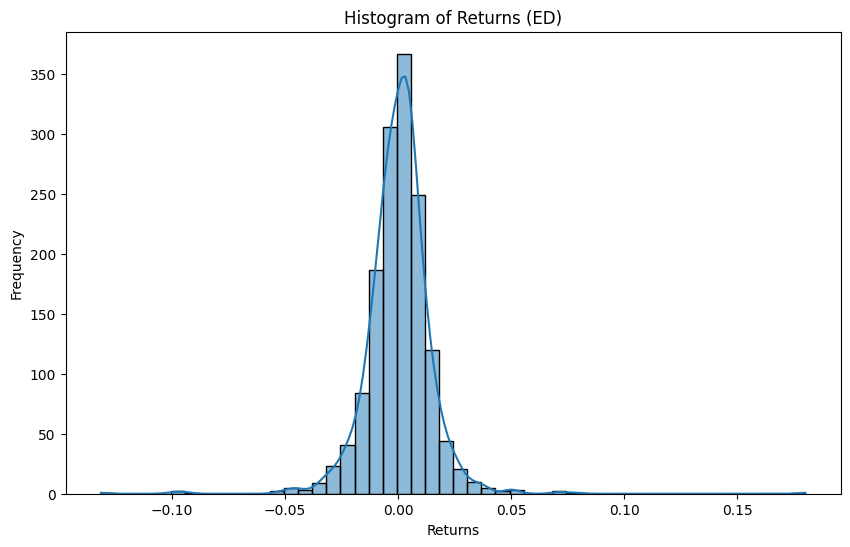

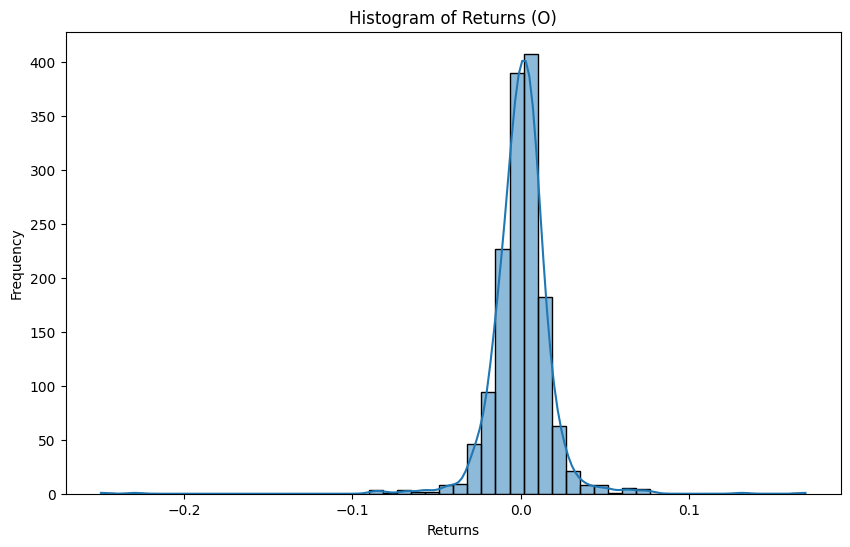

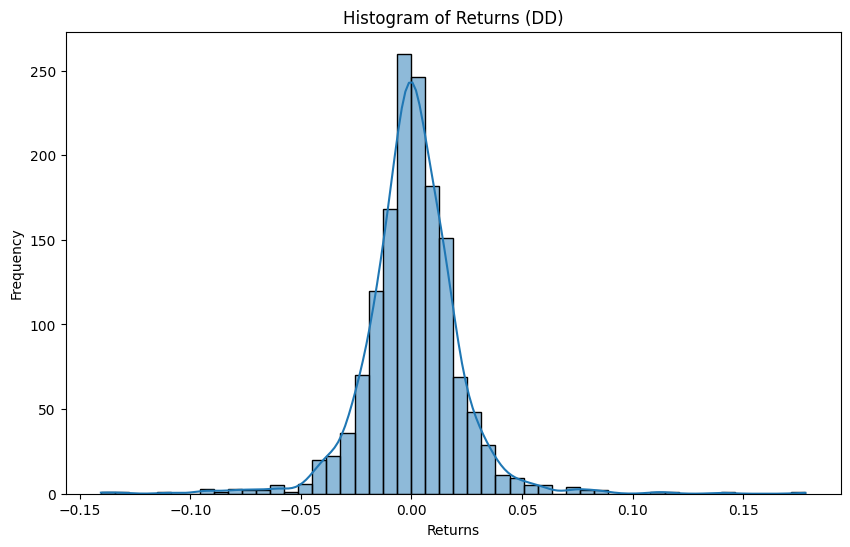

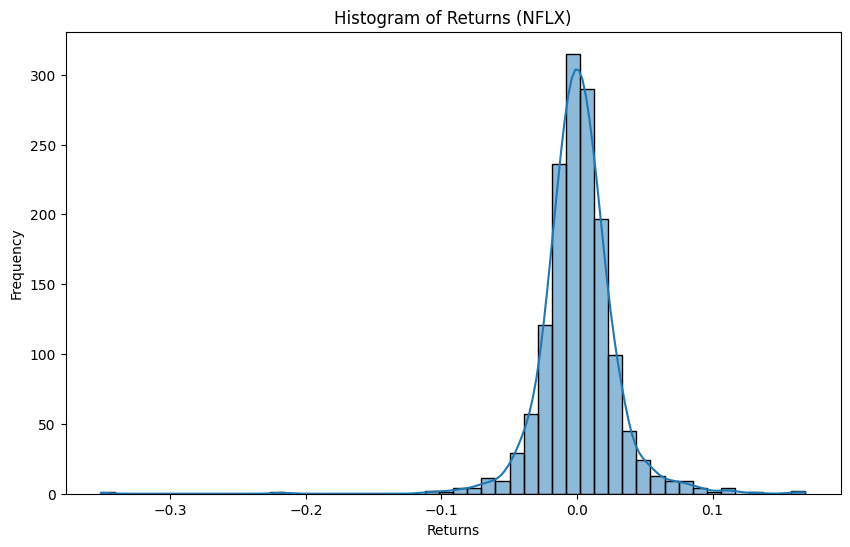

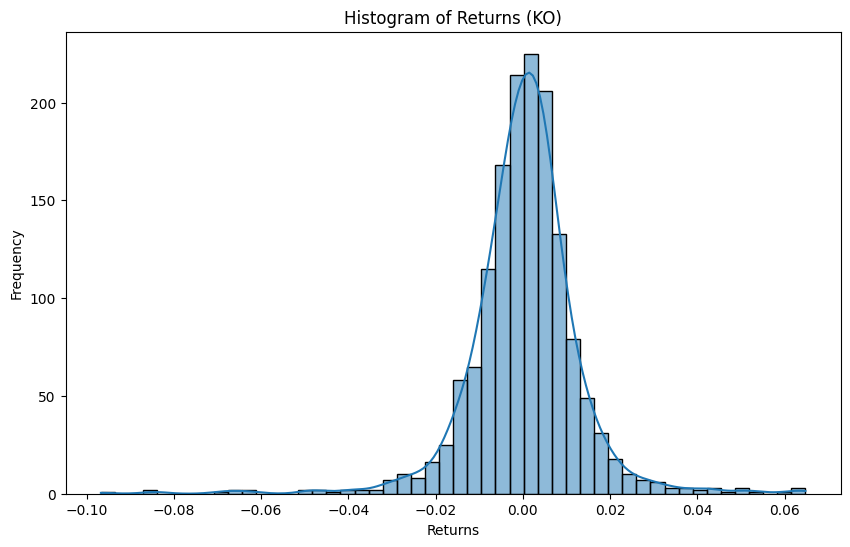

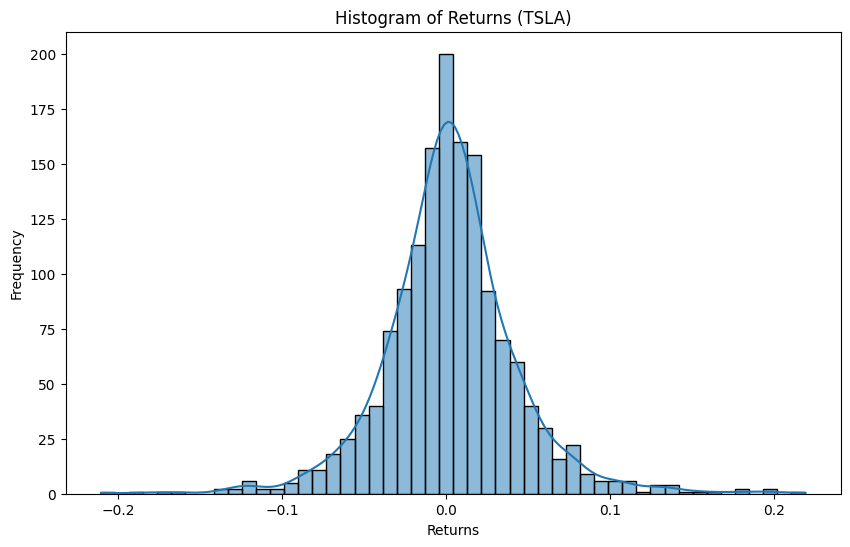

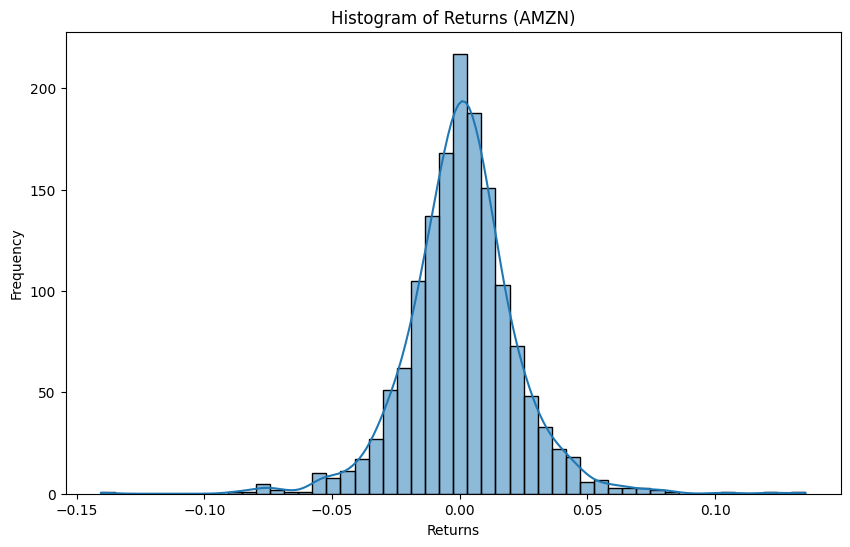

In [59]:
# Histogram Plot of Daily Data
for column in daily.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(daily[column], bins=50, kde=True)
    plt.title(f'Histogram of Returns ({column})')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.savefig(f"./Daily/Histogram Plot/{column}.png")
    plt.show()

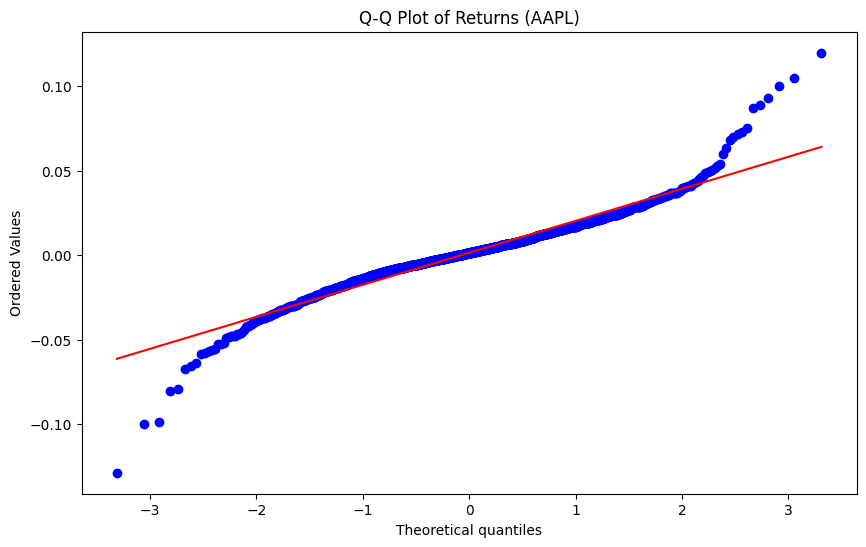

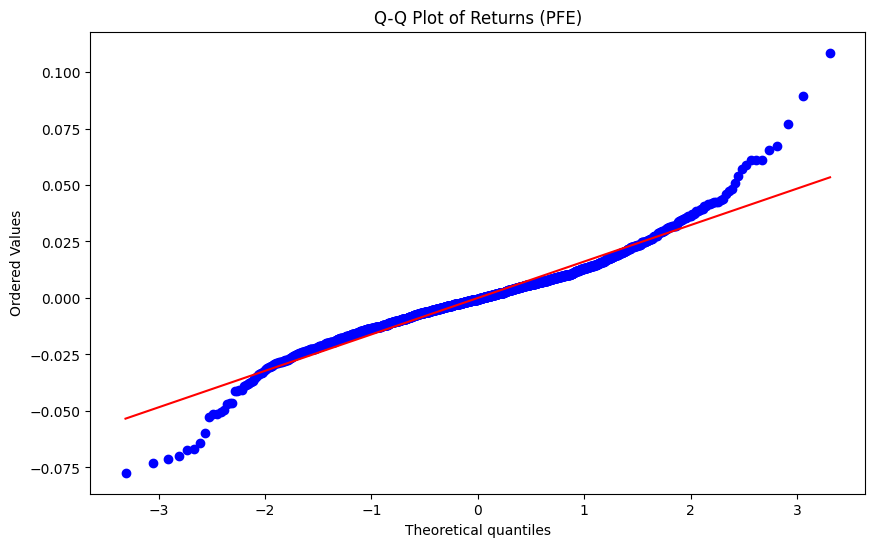

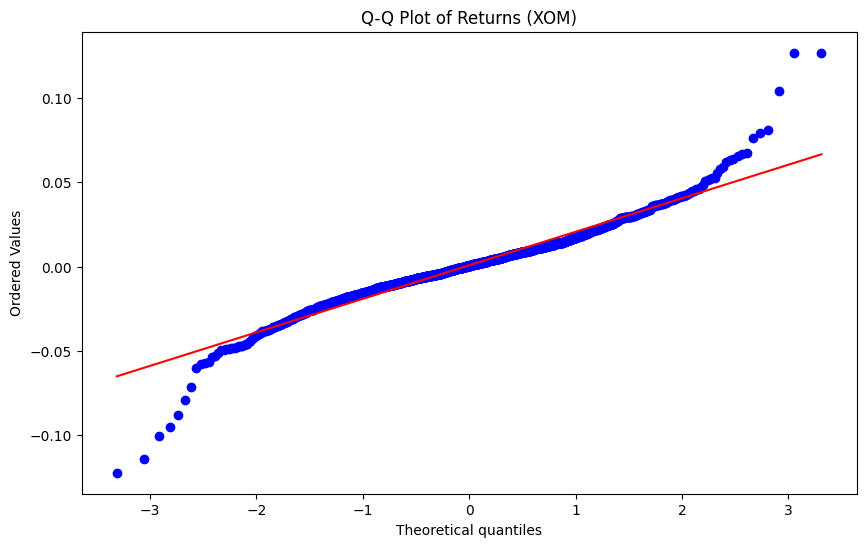

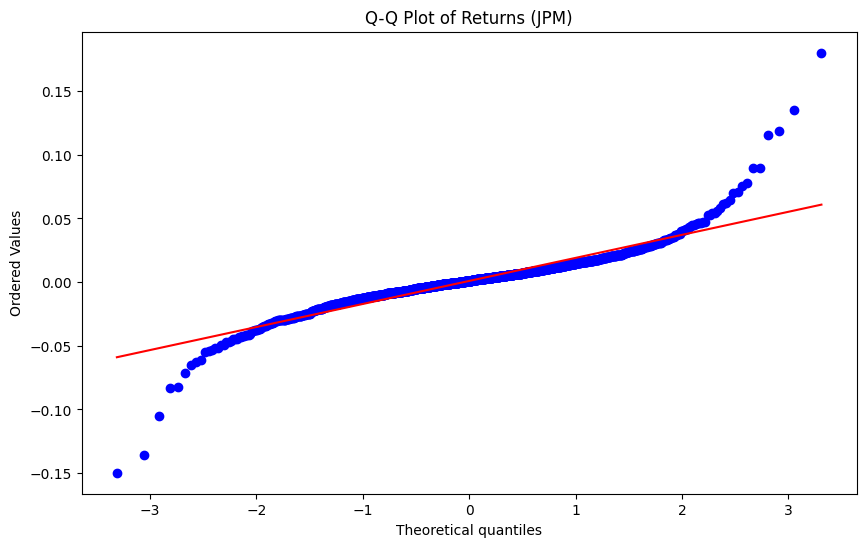

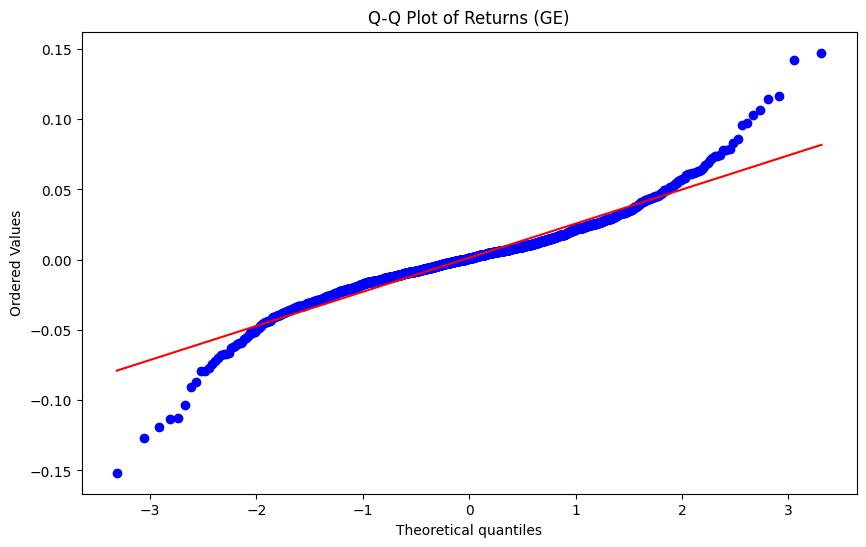

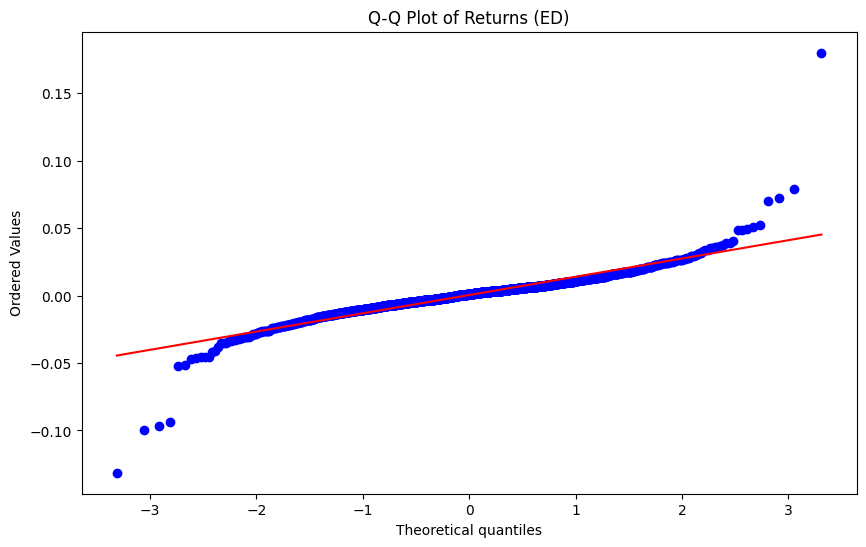

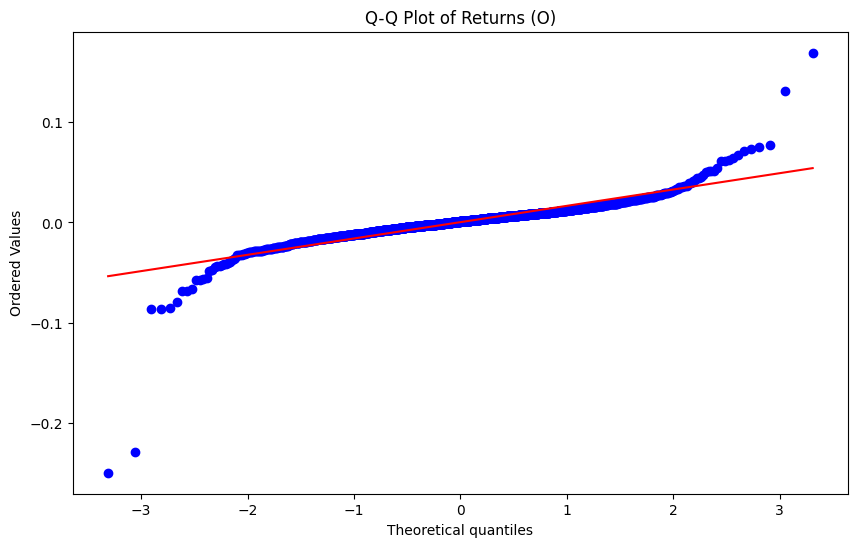

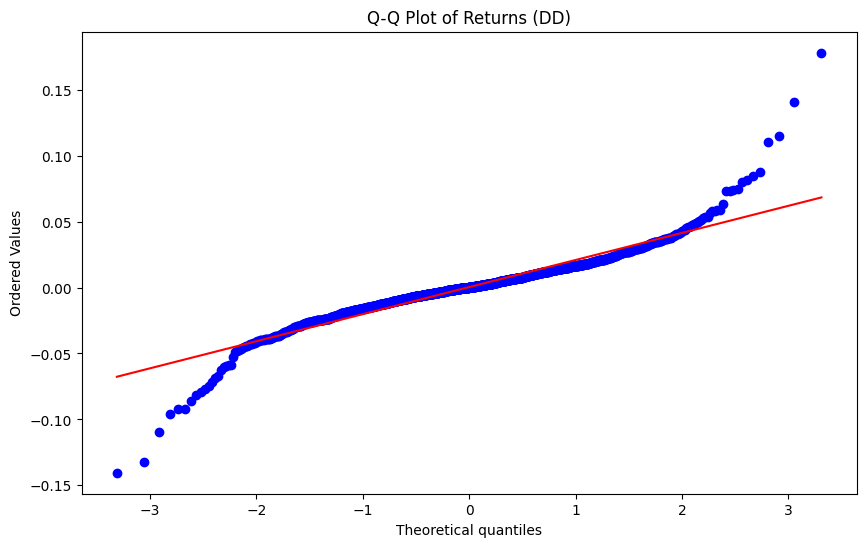

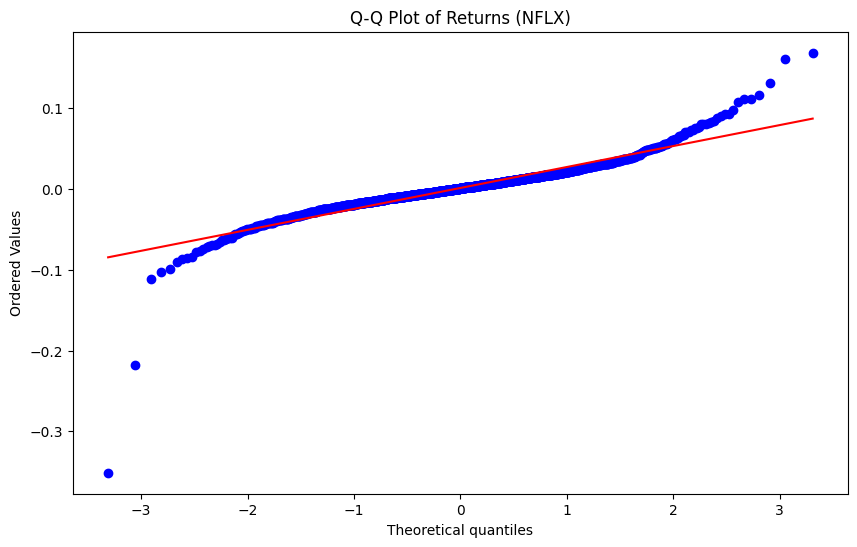

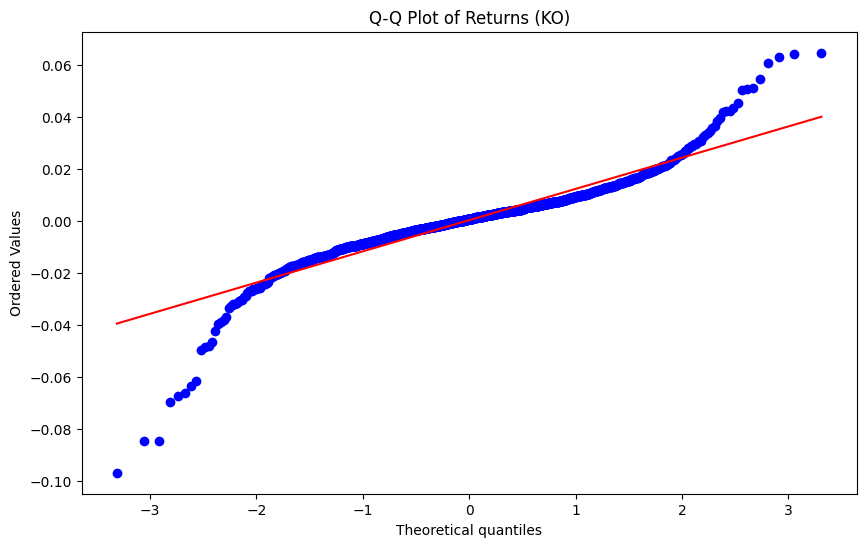

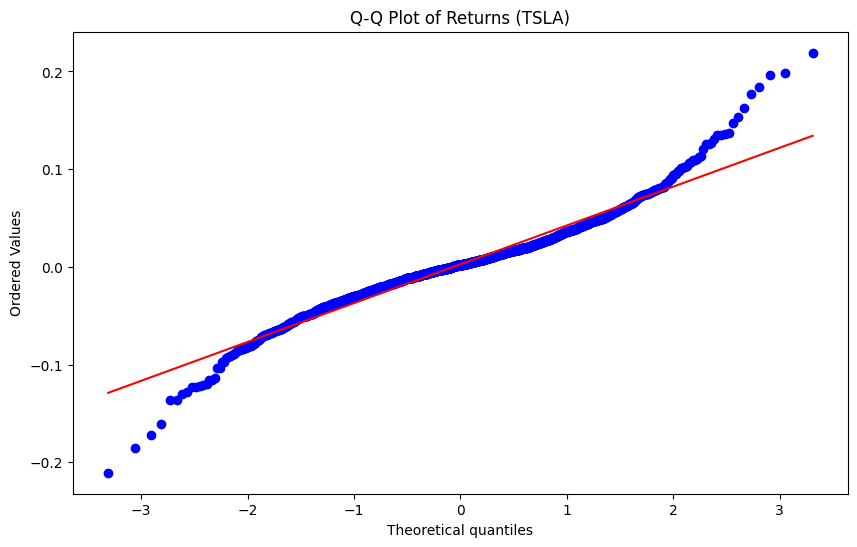

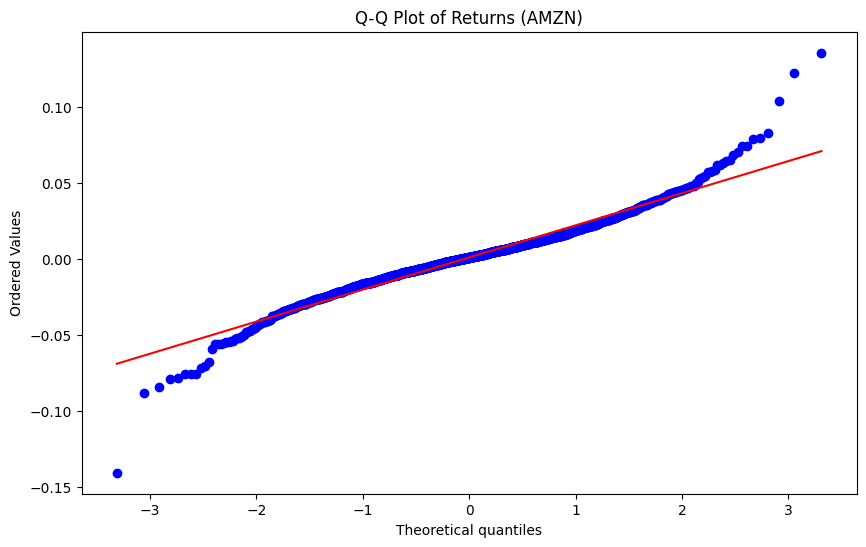

In [60]:
# Q-Q Plot of Daily Data
for column in daily.columns:
    plt.figure(figsize=(10, 6))
    stats.probplot(daily[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Returns ({column})')
    plt.savefig(f"./Daily/Q-Q Plot/{column}.png")
    plt.show()

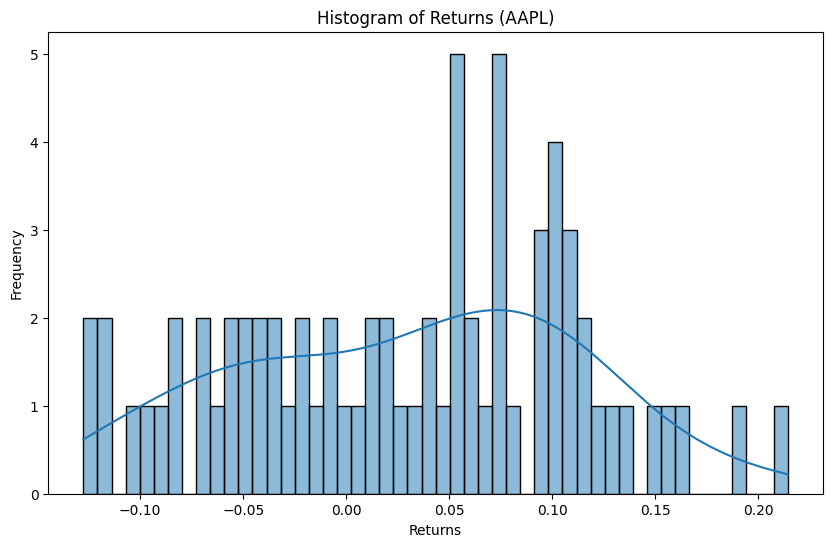

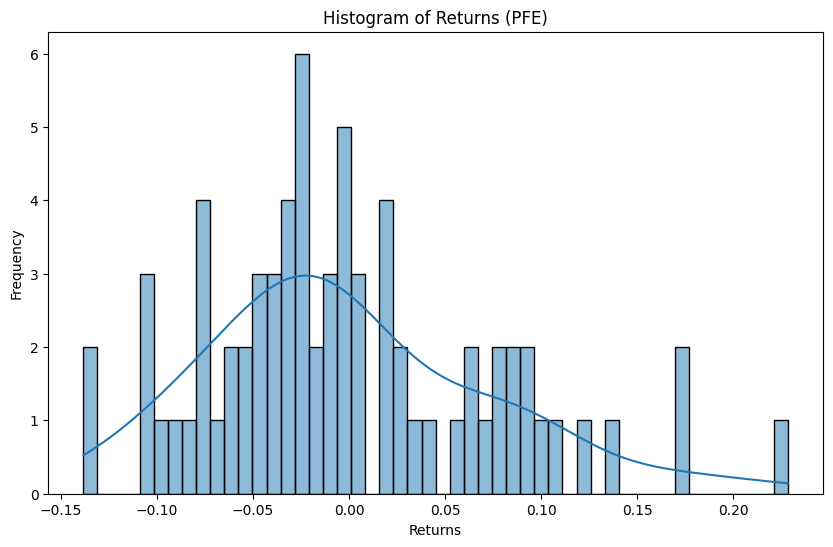

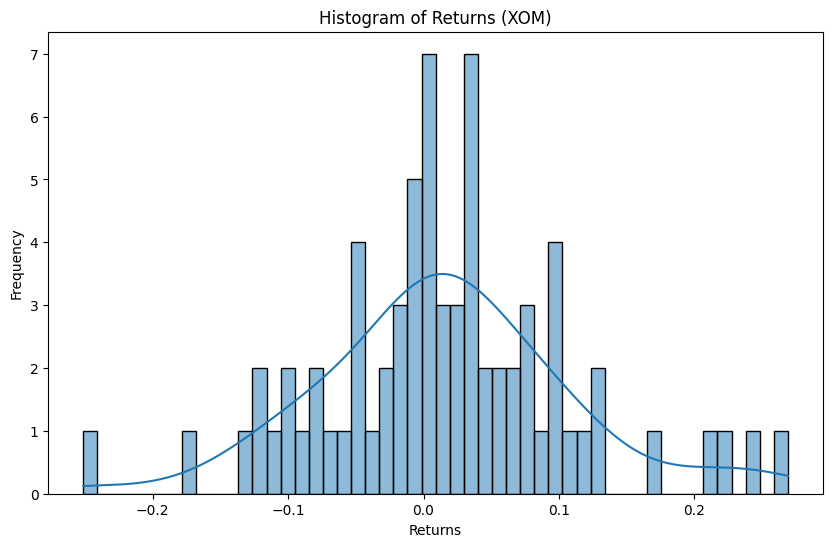

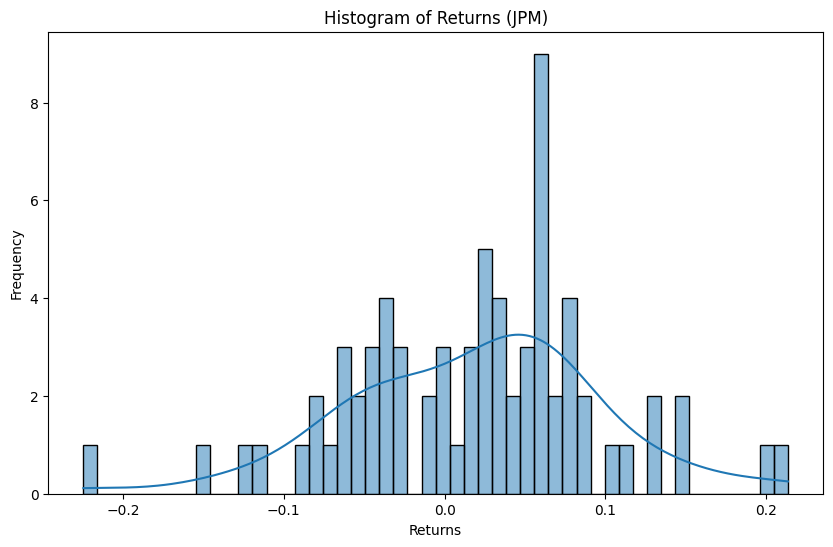

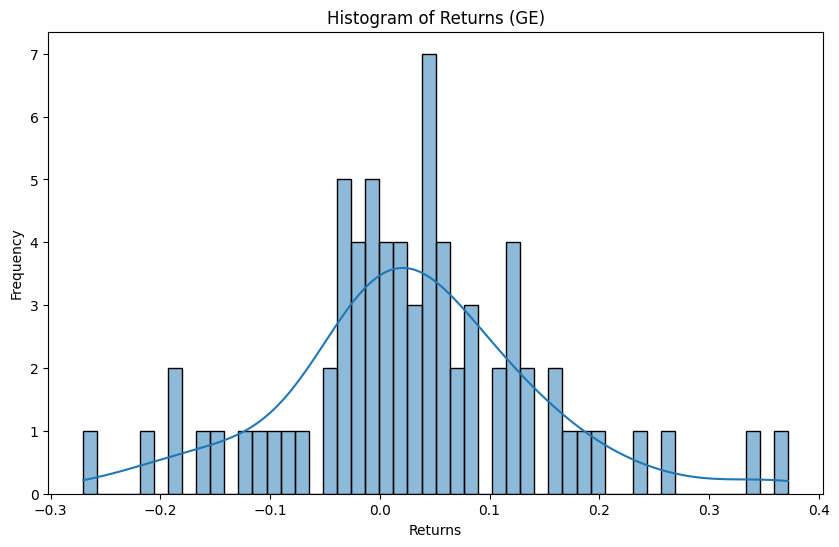

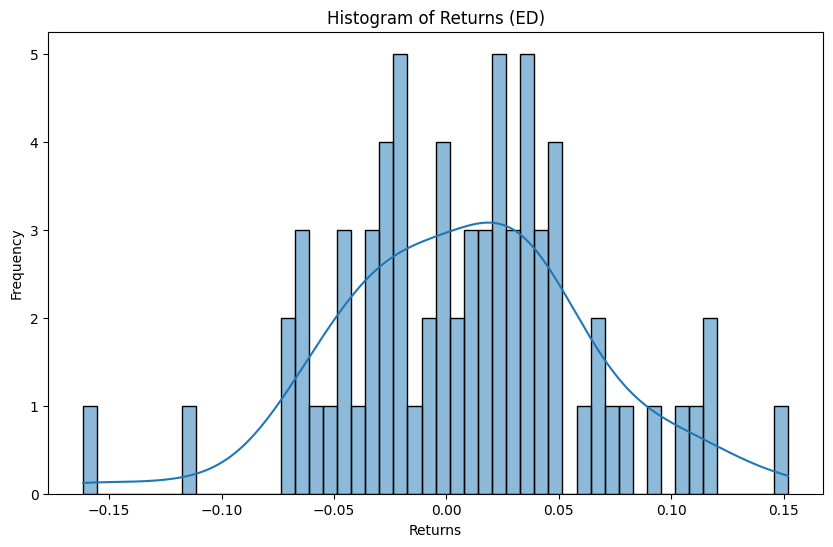

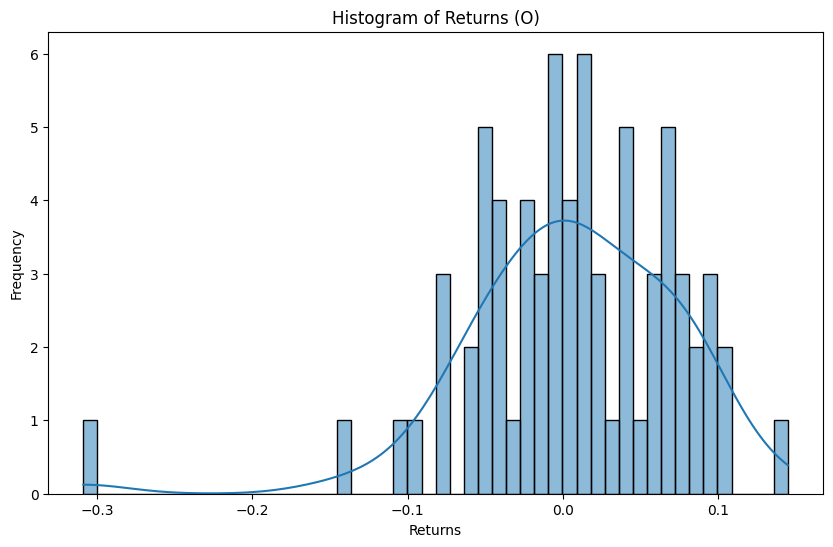

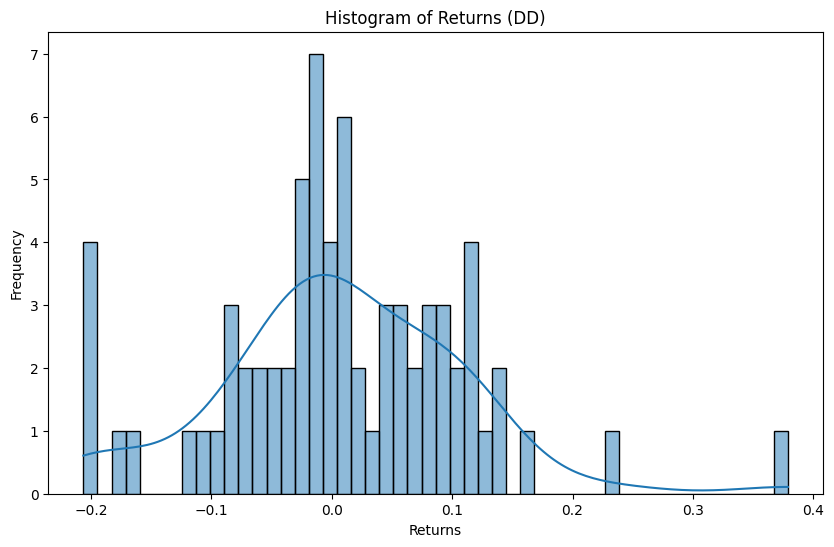

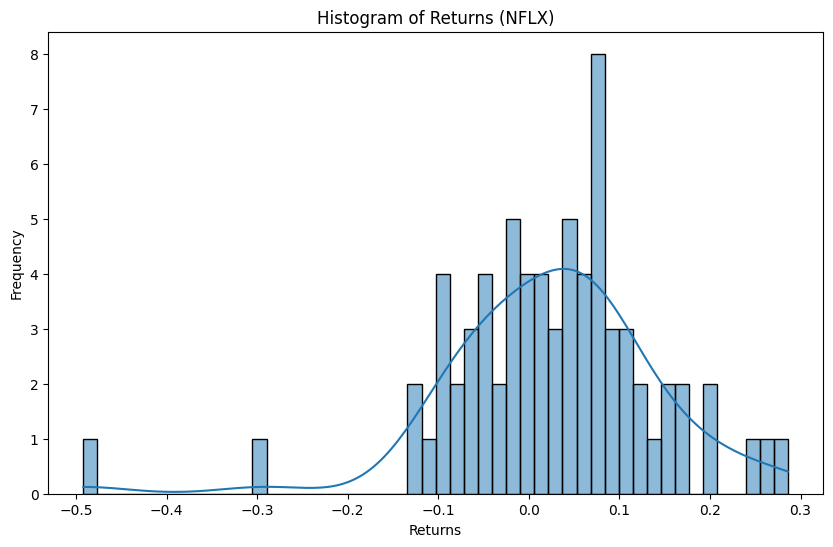

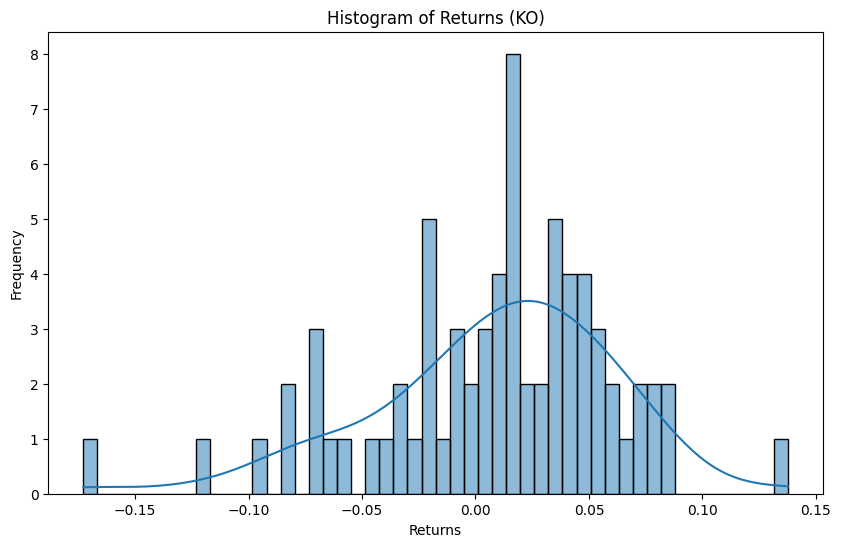

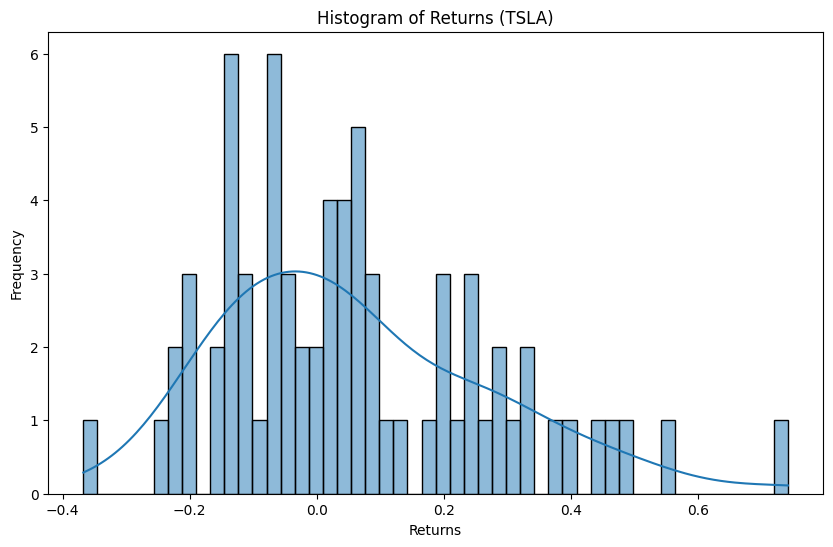

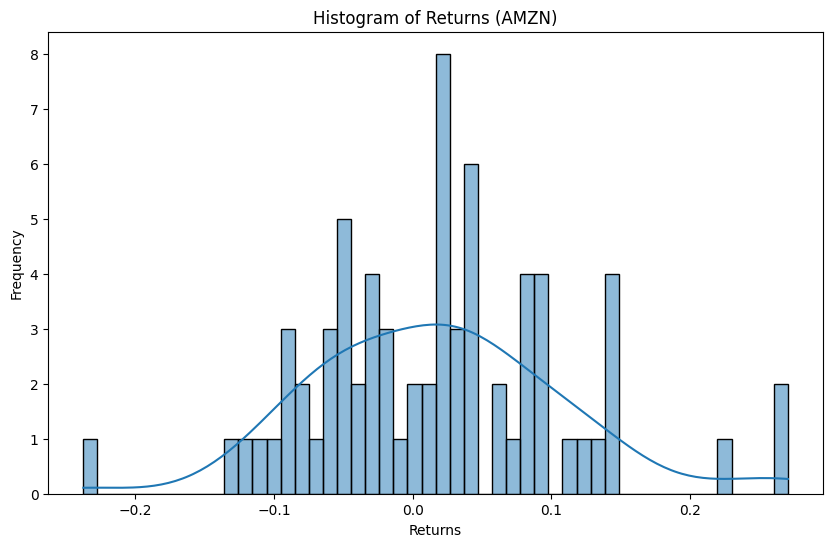

In [61]:
# Histogram Plot of Monthly Data
for column in monthly.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(monthly[column], bins=50, kde=True)
    plt.title(f'Histogram of Returns ({column})')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.savefig(f"./Monthly/Histogram Plot/{column}.png")
    plt.show()

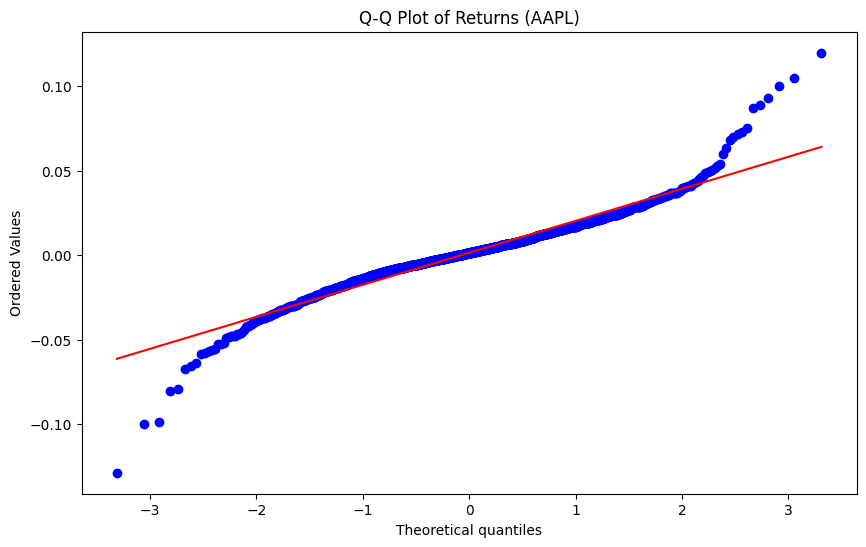

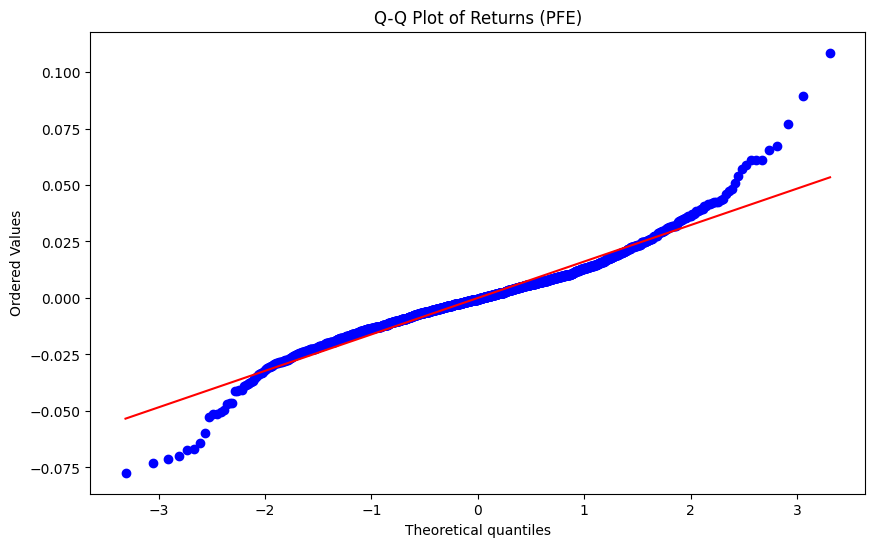

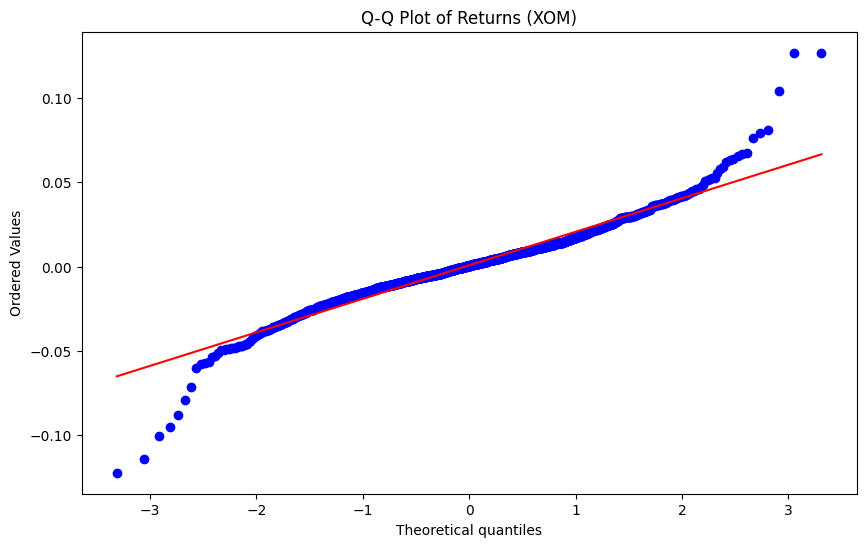

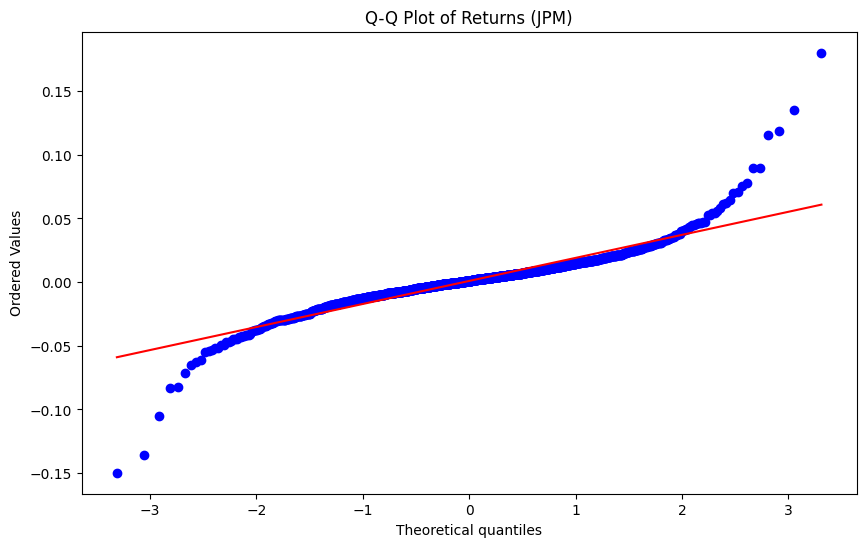

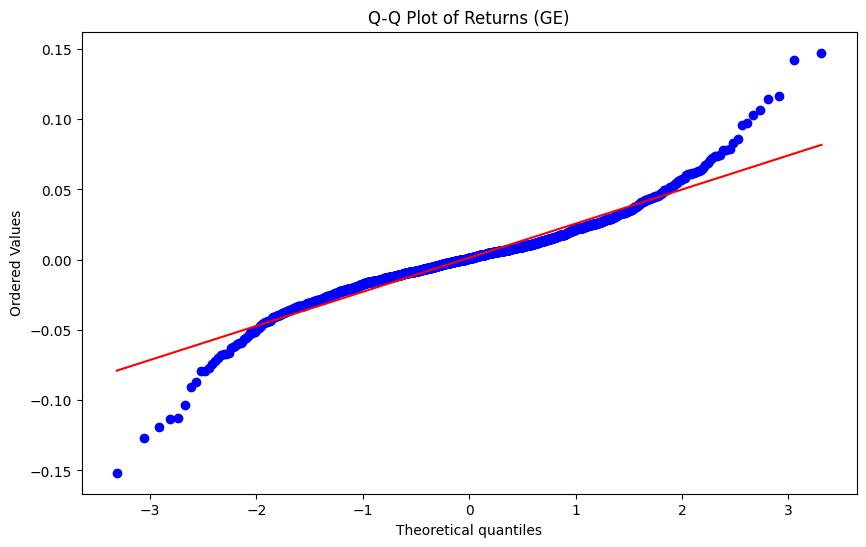

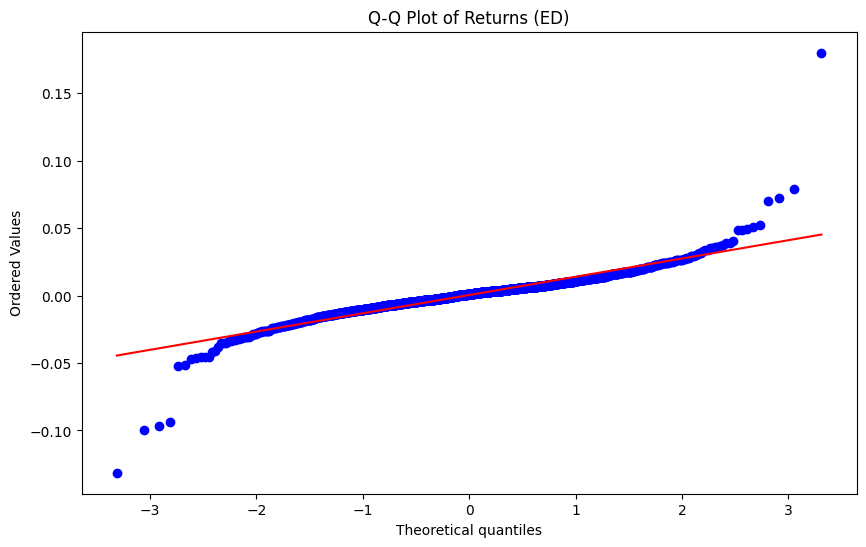

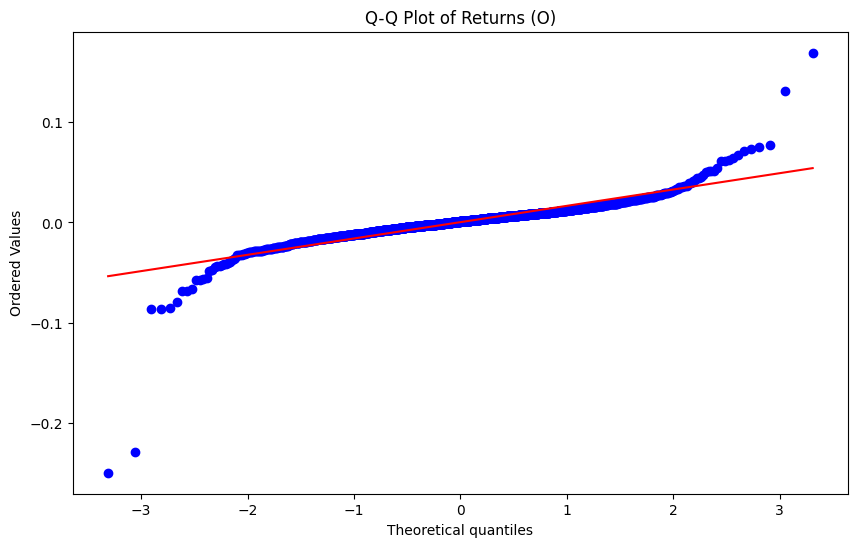

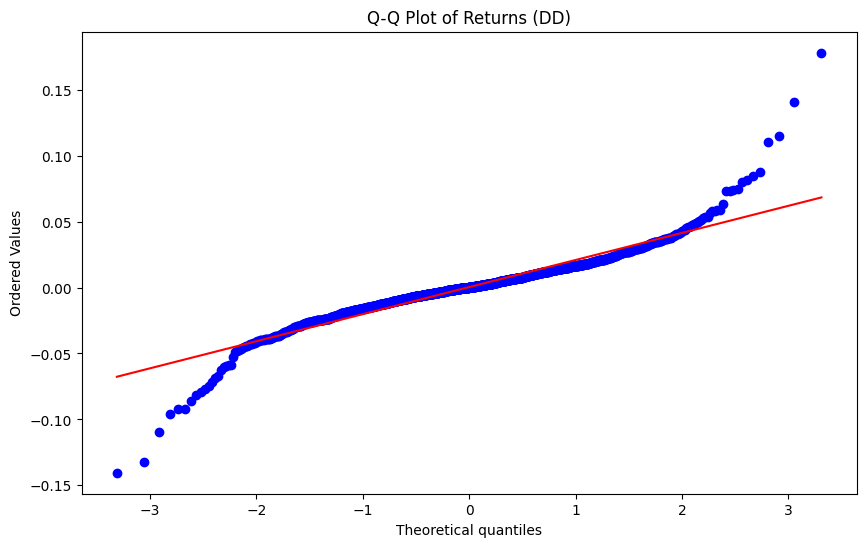

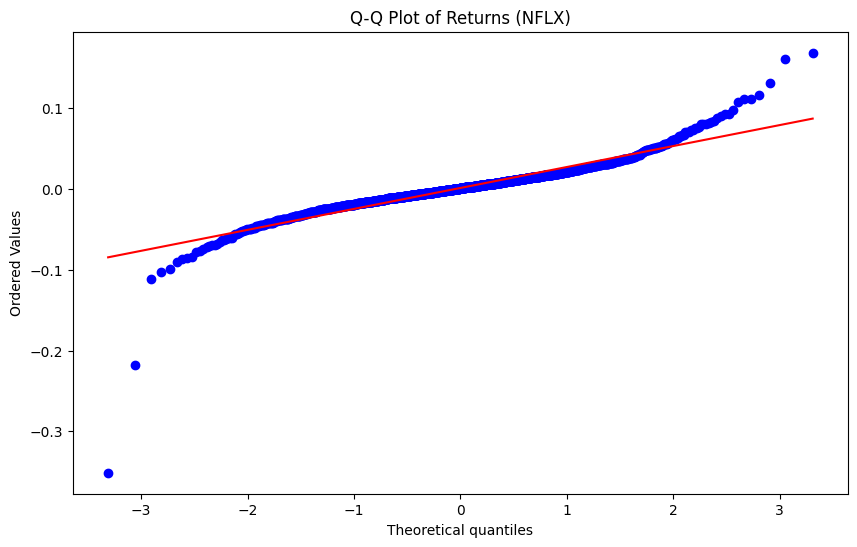

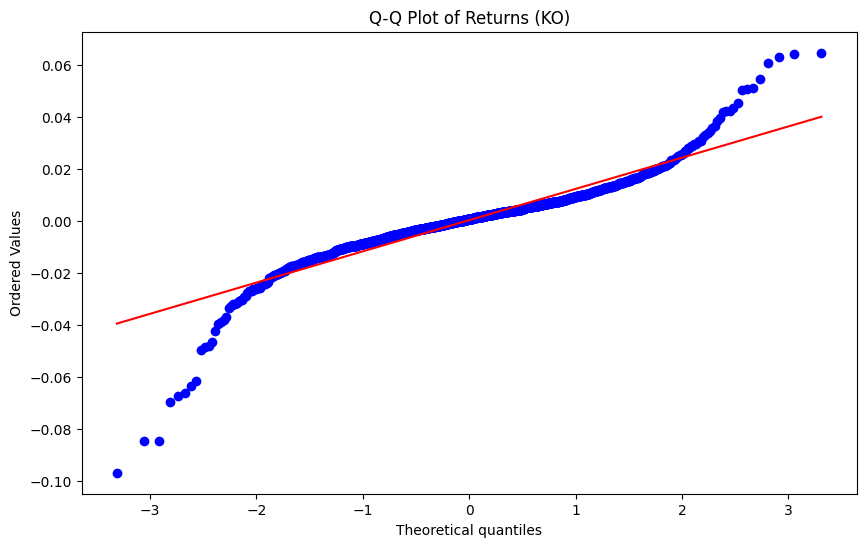

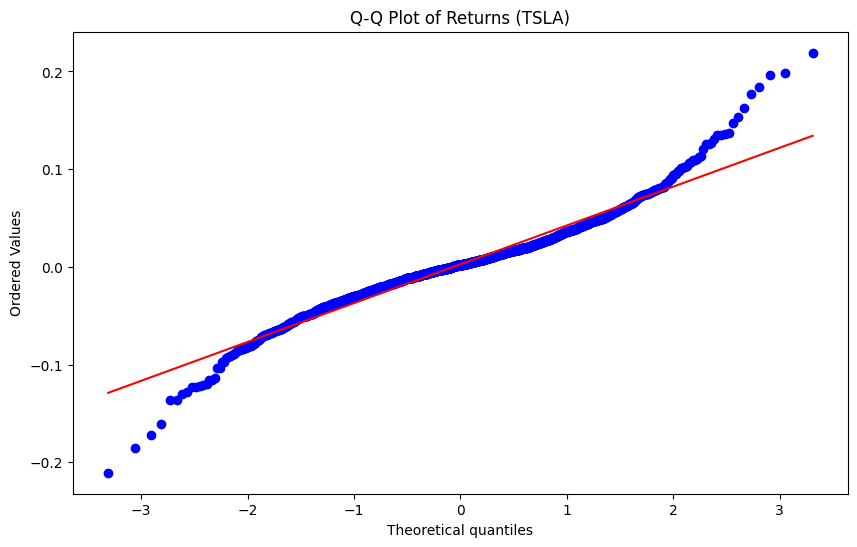

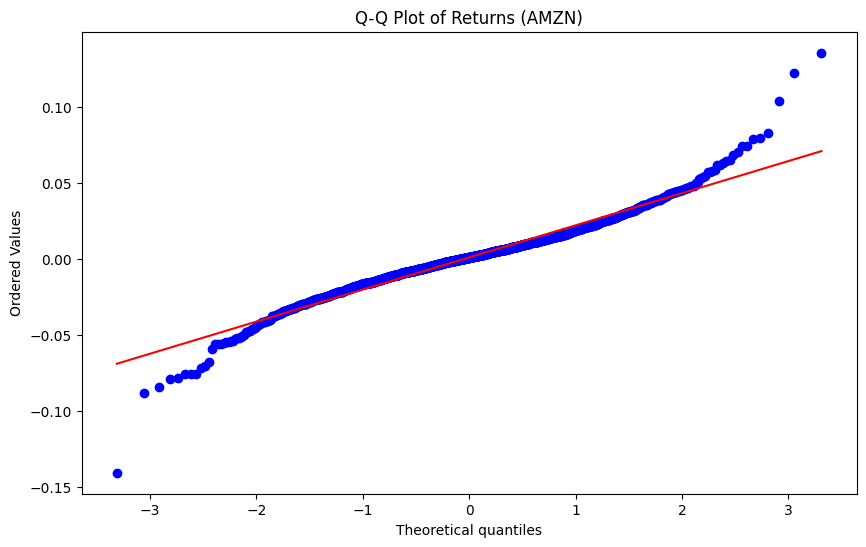

In [62]:
# Q-Q Plot of Monthly Data
for column in monthly.columns:
    plt.figure(figsize=(10, 6))
    stats.probplot(daily[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Returns ({column})')
    plt.savefig(f"./Monthly/Q-Q Plot/{column}.png")
    plt.show()

#### (3) Shapiro-Wilk Test for Normality Test

Shapiro-Wilk Test for Normality:

- Shapiro-Wilk Test Statistic: Close to 1 if the data is normally distributed.

- p-value: If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the data is not normally distributed.

In [63]:
# Shapiro-Wilk Test of Daily Data
shapiro_result = pd.DataFrame(columns=[["S-W Statistic", "P-value"]])

for column in daily.columns:
    SW = shapiro(daily[column])
    shapiro_result.loc[column, "S-W Statistic"] = SW[0]
    shapiro_result.loc[column, "P-value"] = SW[1]
shapiro_result

S-W Statistic P-value
AAPL      0.940156     0.0
PFE       0.950774     0.0
XOM       0.947739     0.0
JPM        0.87189     0.0
GE        0.935816     0.0
ED        0.854379     0.0
O         0.769582     0.0
DD        0.906143     0.0
NFLX      0.872495     0.0
KO        0.884067     0.0
TSLA      0.954579     0.0
AMZN      0.956404     0.0

In [64]:
# Shapiro-Wilk Test of Monthly Data
shapiro_result = pd.DataFrame(columns=[["S-W Statistic", "P-value"]])

for column in monthly.columns:
    SW = shapiro(monthly[column])
    shapiro_result.loc[column, "S-W Statistic"] = SW[0]
    shapiro_result.loc[column, "P-value"] = SW[1]
shapiro_result

S-W Statistic   P-value
AAPL      0.976943  0.215641
PFE       0.963221  0.035672
XOM       0.978099   0.24981
JPM       0.981791  0.392323
GE         0.97302  0.129449
ED        0.987179  0.688022
O         0.920111   0.00024
DD        0.960266  0.024333
NFLX      0.921637  0.000281
KO        0.962033  0.030571
TSLA      0.955662  0.013549
AMZN      0.975364  0.175871

### 2.2.4 Check for Outliers and Fit Distributions

#### (1) Box Plots

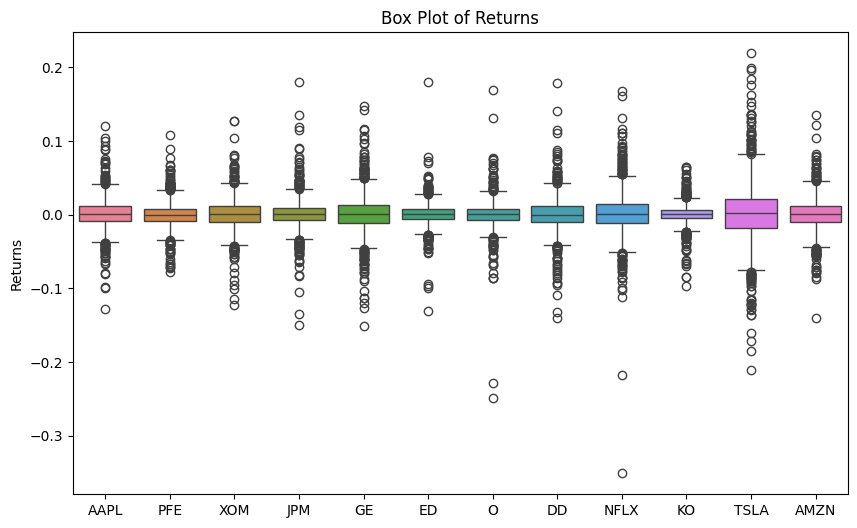

In [65]:
# Box Plot of Daily Data
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily)
plt.title('Box Plot of Returns')
plt.ylabel('Returns')
plt.show()

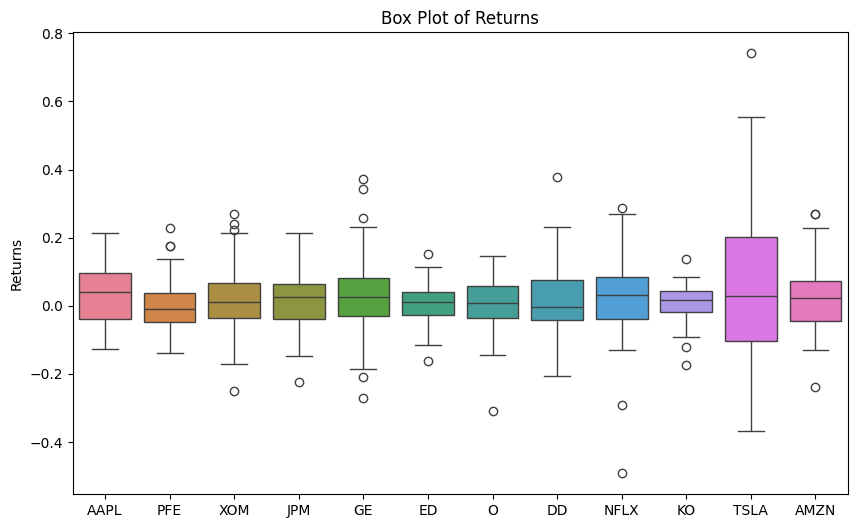

In [66]:
# Box Plot of Monthly Data
plt.figure(figsize=(10, 6))
sns.boxplot(data=monthly)
plt.title('Box Plot of Returns')
plt.ylabel('Returns')
plt.show()

#### (2) Z-Score Method to Check Outliers

In [67]:
# Z_score Method for Daily Data
Z_daily = (daily - daily.mean()) / daily.std()
threshold = 3
outliers = Z_daily[np.abs(Z_daily) >= threshold]
outliers.dropna(axis=0, how="all")

AAPL  PFE  XOM       JPM        GE  ED   O  \
Date                                                                        
2019-01-03 00:00:00-05:00 -5.175773  NaN  NaN       NaN       NaN NaN NaN   
2019-01-04 00:00:00-05:00       NaN  NaN  NaN       NaN       NaN NaN NaN   
2019-01-18 00:00:00-05:00       NaN  NaN  NaN       NaN       NaN NaN NaN   
2019-01-30 00:00:00-05:00  3.427494  NaN  NaN       NaN       NaN NaN NaN   
2019-01-31 00:00:00-05:00       NaN  NaN  NaN       NaN  4.588954 NaN NaN   
...                             ...  ...  ...       ...       ...  ..  ..   
2024-08-02 00:00:00-04:00       NaN  NaN  NaN       NaN       NaN NaN NaN   
2024-10-18 00:00:00-04:00       NaN  NaN  NaN       NaN       NaN NaN NaN   
2024-10-22 00:00:00-04:00       NaN  NaN  NaN       NaN -3.663968 NaN NaN   
2024-10-24 00:00:00-04:00       NaN  NaN  NaN       NaN       NaN NaN NaN   
2024-11-06 00:00:00-05:00       NaN  NaN  NaN  5.904859       NaN NaN NaN   

                                 DD      NFLX  KO      TSLA      AMZN  
Date                                                                   
2019-01-03 00:00:00-05:00       NaN       NaN NaN       NaN       NaN  
2019-01-04 00:00:00-05:00       NaN  3.456998 NaN       NaN       NaN  
2019-01-18 00:00:00-05:00       NaN       NaN NaN -3.257358       NaN  
2019-01-30 00:00:00-05:00       NaN       NaN NaN       NaN       NaN  
2019-01-31 00:00:00-05:00 -4.291808       NaN NaN       NaN       NaN  
...                             ...       ...  ..       ...       ...  
2024-08-02 00:00:00-04:00       NaN       NaN NaN       NaN -4.117645  
2024-10-18 00:00:00-04:00       NaN  3.947870 NaN       NaN       NaN  
2024-10-22 00:00:00-04:00       NaN       NaN NaN       NaN       NaN  
2024-10-24 00:00:00-04:00       NaN       NaN NaN  5.327849       NaN  
2024-11-06 00:00:00-05:00       NaN       NaN NaN  3.564062       NaN  

[161 rows x 12 columns]

In [68]:
# Z_score Method for Monthly Data
Z_monthly = (monthly - monthly.mean()) / monthly.std()
threshold = 3
outliers = Z_monthly[np.abs(Z_monthly) >= threshold]
outliers.dropna(axis=0, how="all")

AAPL      PFE  XOM       JPM  GE        ED  \
Date                                                                    
2020-02-01 00:00:00-05:00   NaN      NaN  NaN       NaN NaN -3.078379   
2020-03-01 00:00:00-05:00   NaN      NaN  NaN -3.111507 NaN       NaN   
2020-04-01 00:00:00-04:00   NaN      NaN  NaN       NaN NaN       NaN   
2020-08-01 00:00:00-04:00   NaN      NaN  NaN       NaN NaN       NaN   
2021-11-01 00:00:00-04:00   NaN  3.06178  NaN       NaN NaN       NaN   
2022-04-01 00:00:00-04:00   NaN      NaN  NaN       NaN NaN       NaN   

                                  O        DD      NFLX        KO      TSLA  \
Date                                                                          
2020-02-01 00:00:00-05:00       NaN       NaN       NaN       NaN       NaN   
2020-03-01 00:00:00-05:00 -4.556718       NaN       NaN -3.399948       NaN   
2020-04-01 00:00:00-04:00       NaN  3.644252       NaN       NaN       NaN   
2020-08-01 00:00:00-04:00       NaN       NaN       NaN       NaN  3.186065   
2021-11-01 00:00:00-04:00       NaN       NaN       NaN       NaN       NaN   
2022-04-01 00:00:00-04:00       NaN       NaN -4.391884       NaN       NaN   

                           AMZN  
Date                             
2020-02-01 00:00:00-05:00   NaN  
2020-03-01 00:00:00-05:00   NaN  
2020-04-01 00:00:00-04:00   NaN  
2020-08-01 00:00:00-04:00   NaN  
2021-11-01 00:00:00-04:00   NaN  
2022-04-01 00:00:00-04:00   NaN

#### (3) Fit Different Distributions (Normal and Student-t Distribution)

In [69]:
# Fit Different Distributions on Daily Data
daily_best_distribution = pd.DataFrame(columns=["Distribution", "Degree of Freedom", "Mean", "Standard Deviation", "P-value"])

for column in daily.columns:
    data = daily[column]
    params_norm = stats.norm.fit(data)
    loc_norm, scale_norm = params_norm # loc means mean, scale means standard deviation
    params_t = stats.t.fit(data)
    df_t, loc_t, scale_t = params_t # df means degree of freedom, loc means mean, scale means standard deviation

    ks_stat_normal, ks_pvalue_norm = stats.kstest(data, 'norm', params_norm)
    ks_stat_t, ks_pvalue_t = stats.kstest(data, 't', params_t)
    if ks_pvalue_norm >= ks_pvalue_t: # Higher p-values suggest a better fit or Estimated df >= 30
        daily_best_distribution.loc[column, "Distribution"] = "Normal"
        daily_best_distribution.loc[column, "Mean"] = loc_norm
        daily_best_distribution.loc[column, "Standard Deviation"] = scale_norm
        daily_best_distribution.loc[column, "P-value"] = ks_pvalue_norm
    else:
        daily_best_distribution.loc[column, "Distribution"] = "T"
        daily_best_distribution.loc[column, "Degree of Freedom"] = int(np.around(df_t))
        daily_best_distribution.loc[column, "Mean"] = loc_t
        daily_best_distribution.loc[column, "Standard Deviation"] = scale_t
        daily_best_distribution.loc[column, "P-value"] = ks_pvalue_t

daily_best_distribution

Distribution Degree of Freedom      Mean Standard Deviation   P-value
AAPL            T                 4  0.001567           0.013293  0.970559
PFE             T                 4  -0.00038           0.011479  0.975692
XOM             T                 4  0.000582           0.014487  0.847612
JPM             T                 3   0.00097             0.0112  0.982644
GE              T                 3  0.000938             0.0162   0.79203
ED              T                 3  0.000713           0.009015   0.46125
O               T                 3  0.000762           0.009996  0.555258
DD              T                 3  0.000415           0.013556  0.764091
NFLX            T                 3  0.000746           0.017097  0.982997
KO              T                 3  0.000692           0.007377  0.851415
TSLA            T                 3  0.001976           0.027576  0.692792
AMZN            T                 4  0.000858           0.015366  0.979351

In [70]:
# Fit Different Distributions on Monthly Data
monthly_best_distribution = pd.DataFrame(columns=["Distribution", "Degree of Freedom", "Mean", "Standard Deviation", "P-value"])

for column in monthly.columns:
    data = monthly[column]
    params_norm = stats.norm.fit(data)
    loc_norm, scale_norm = params_norm # loc means mean, scale means standard deviation
    params_t = stats.t.fit(data)
    df_t, loc_t, scale_t = params_t # df means degree of freedom, loc means mean, scale means standard deviation

    ks_stat_normal, ks_pvalue_norm = stats.kstest(data, 'norm', params_norm)
    ks_stat_t, ks_pvalue_t = stats.kstest(data, 't', params_t)
    if ks_pvalue_norm >= ks_pvalue_t: # Higher p-values suggest a better fit
        monthly_best_distribution.loc[column, "Distribution"] = "Normal"
        monthly_best_distribution.loc[column, "Mean"] = loc_norm
        monthly_best_distribution.loc[column, "Standard Deviation"] = scale_norm
        monthly_best_distribution.loc[column, "P-value"] = ks_pvalue_norm
    else:
        monthly_best_distribution.loc[column, "Distribution"] = "T"
        monthly_best_distribution.loc[column, "Degree of Freedom"] = int(np.around(df_t))
        monthly_best_distribution.loc[column, "Mean"] = loc_t
        monthly_best_distribution.loc[column, "Standard Deviation"] = scale_t
        monthly_best_distribution.loc[column, "P-value"] = ks_pvalue_t

monthly_best_distribution

Distribution Degree of Freedom      Mean Standard Deviation   P-value
AAPL       Normal               NaN  0.029534           0.081834  0.690207
PFE             T                11  -0.00423           0.067445  0.511217
XOM             T                 5  0.013581           0.072484  0.964657
JPM             T                 9  0.020079           0.069102  0.845495
GE              T                 4  0.027464           0.084077  0.828909
ED              T                10  0.008357           0.049344  0.960775
O               T                 6  0.009474           0.054282  0.942476
DD              T                 5   0.00749           0.081215  0.729975
NFLX            T                 4  0.028935           0.082919  0.974002
KO              T                 6  0.012435           0.043867  0.814633
TSLA            T                15  0.049982           0.197631  0.413455
AMZN            T                 8  0.015399           0.078174  0.927458

Generally, we consider t-distributions with degree of freedom higher than 30 as normal distribution to make calculation easier. But here we just use the more accurate result.

### 2.2.5 Compute Sharpe Ratio

In [71]:
# Sharpe Ratio of Daily Data
sharperatio = pd.DataFrame()

for column in daily.columns:
    data = daily[column]
    sharperatio.loc[column, "Sharpe Ratio"] = (data.mean() - daily_risk_free_rate) / data.std() * np.sqrt(252)

sharperatio

Sharpe Ratio
AAPL      1.091077
PFE      -0.084857
XOM       0.532655
JPM       0.696057
GE        0.841406
ED        0.381765
O         0.203566
DD        0.211930
NFLX      0.638567
KO        0.403480
TSLA      1.008430
AMZN      0.611546

In [72]:
# Sharpe Ratio of Monthly Data
sharperatio = pd.DataFrame()

for column in monthly.columns:
    data = monthly[column]
    sharperatio.loc[column, "Sharpe Ratio"] = (data.mean() - monthly_risk_free_rate) / data.std() * np.sqrt(12)

sharperatio

Sharpe Ratio
AAPL      1.165702
PFE      -0.104192
XOM       0.527333
JPM       0.754673
GE        0.838570
ED        0.411052
O         0.188545
DD        0.209064
NFLX      0.673793
KO        0.418422
TSLA      0.934302
AMZN      0.633281

## 2.3 Portfolio Theory

### 2.3.1 Construct Minimum Variance Portfolio

In [115]:
# MVP of Daily Data
from scipy.optimize import minimize

def port_statistics(weights, mean_returns, cov_matrix): # Multiply 252 to compare daily data with annual return
    port_mean = np.sum(mean_returns * weights) * 252
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return port_mean, port_std

def port_var(weights, mean_returns, cov_matrix): 
    return port_statistics(weights, mean_returns, cov_matrix)[1] ** 2

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(
        port_var,
        num_assets * [1. / num_assets], 
        args=args,
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    return result


mean_returns = daily.mean()
cov_matrix = daily.cov()

result = min_variance(mean_returns, cov_matrix)
daily_weights = result.x
daily_mean_return, daily_std = port_statistics(daily_weights, mean_returns, cov_matrix)
daily_portfolio_returns = daily.dot(daily_weights)
daily_VaR = np.percentile(daily_portfolio_returns, 5)
daily_ES = daily_portfolio_returns[daily_portfolio_returns <= daily_VaR].mean()

print(f"Weights: {daily_weights}")
print(f"Mean Return: {daily_mean_return}")
print(f"Standard Deviation: {daily_std}")
print(f"Value-at-Risk (VaR): {daily_VaR}")
print(f"Expected Shortfall (ES): {daily_ES}")

Weights: [1.62750748e-18 1.64513576e-01 8.45151705e-02 2.19055039e-18
 3.80584985e-18 2.38759866e-01 1.25444064e-02 2.90809112e-20
 5.78910391e-02 3.34948432e-01 2.10556721e-04 1.06616954e-01]
Mean Return: 0.12067727005504628
Standard Deviation: 0.16914445968745412
Value-at-Risk (VaR): -0.01481706766625461
Expected Shortfall (ES): -0.024717404606085593


In [74]:
# MVP of Monthly Data
def port_statistics(weights, mean_returns, cov_matrix): # Multiply 12 to compare monthly data with annual return
    port_mean = np.sum(mean_returns * weights) * 12
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return port_mean, port_std

def port_var(weights, mean_returns, cov_matrix): 
    return port_statistics(weights, mean_returns, cov_matrix)[1] ** 2

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(
        port_var,
        num_assets * [1. / num_assets], 
        args=args,
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    return result

mean_returns = monthly.mean()
cov_matrix = monthly.cov()

result = min_variance(mean_returns, cov_matrix)
monthly_weights = result.x
monthly_mean_return, monthly_std = port_statistics(monthly_weights, mean_returns, cov_matrix)
monthly_portfolio_returns = monthly.dot(monthly_weights)
monthly_VaR = np.percentile(monthly_portfolio_returns, 5)
monthly_ES = monthly_portfolio_returns[monthly_portfolio_returns <= monthly_VaR].mean()

print(f"Weights: {monthly_weights}")
print(f"Mean Return: {monthly_mean_return}")
print(f"Standard Deviation: {monthly_std}")
print(f"Value-at-Risk (VaR): {monthly_VaR}")
print(f"Expected Shortfall (ES): {monthly_ES}")

Weights: [0.00000000e+00 9.82856194e-02 6.64297754e-02 1.18520842e-02
 0.00000000e+00 3.16993737e-01 1.61021664e-17 0.00000000e+00
 7.61631054e-02 3.38243333e-01 0.00000000e+00 9.20323464e-02]
Mean Return: 0.12288804667703972
Standard Deviation: 0.13971811752153712
Value-at-Risk (VaR): -0.05409654907354573
Expected Shortfall (ES): -0.07906774472275717


### 2.3.2 Comment on Weights and Annualized Return/Risk

### 2.3.3 Invest $100,000

In [75]:
# Using Annual VaR from Daily Data
investment = 1e5
VaR_d = daily_VaR / np.sqrt(12)
VaR_one_month = VaR_d * investment
print(f"5% VaR over a one-month horizon: ${VaR_one_month:.2f}")

5% VaR over a one-month horizon: $-427.73


In [76]:
# Using Annual VaR from Monthly Data
investment = 1e5
VaR_m = monthly_VaR / np.sqrt(12)
VaR_one_month = VaR_m * investment
print(f"5% VaR over a one-month horizon: ${VaR_one_month:.2f}")

5% VaR over a one-month horizon: $-1561.63


### 2.3.4 Compare VaR with Individual Assets' VaR

In [77]:
# VaRs using Daily Data
daily_VaR_df = pd.DataFrame()
for column in daily.columns:
    data = daily[column]
    daily_VaR_df.loc[column, "VaR"] = np.percentile(data, 5)
daily_VaR_df.loc["MVP", "VaR"] = VaR_d
daily_VaR_df

VaR
AAPL -0.029649
PFE  -0.024011
XOM  -0.030122
JPM  -0.027490
GE   -0.034320
ED   -0.020556
O    -0.023450
DD   -0.030180
NFLX -0.037153
KO   -0.017072
TSLA -0.060814
AMZN -0.032098
MVP  -0.004277

In [78]:
# VaRs using Monthly Data
monthly_VaR_df = pd.DataFrame()
for column in monthly.columns:
    data = monthly[column]
    monthly_VaR_df.loc[column, "VaR"] = np.percentile(data, 5)
monthly_VaR_df.loc["MVP", "VaR"] = VaR_m
monthly_VaR_df

VaR
AAPL -0.108853
PFE  -0.102886
XOM  -0.120982
JPM  -0.104053
GE   -0.170757
ED   -0.066995
O    -0.087988
DD   -0.186740
NFLX -0.117499
KO   -0.084497
TSLA -0.211775
AMZN -0.105726
MVP  -0.015616

### 2.3.5 Construct Minimum Variance Portfolio with Short Sales

In [79]:
# MVP of Daily Data
from scipy.optimize import minimize

def port_statistics(weights, mean_returns, cov_matrix):
    port_mean = np.sum(mean_returns * weights) * 252
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return port_mean, port_std

def port_var(weights, mean_returns, cov_matrix): 
    return port_statistics(weights, mean_returns, cov_matrix)[1] ** 2

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Here reflects the boundary of weights (-1 means allowing short sales)
    bounds = tuple((-1, 1) for _ in range(num_assets))
    result = minimize(
        port_var,
        num_assets * [1. / num_assets], 
        args=args,
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    return result


mean_returns = daily.mean()
cov_matrix = daily.cov()

result_withshort = min_variance(mean_returns, cov_matrix)
daily_weights_withshort = result_withshort.x
daily_mean_return_withshort, daily_std_withshort = port_statistics(daily_weights_withshort, mean_returns, cov_matrix)
daily_portfolio_returns_withshort = daily.dot(daily_weights_withshort)
daily_VaR_withshort = np.percentile(daily_portfolio_returns_withshort, 5)
daily_ES_withshort = daily_portfolio_returns_withshort[daily_portfolio_returns_withshort <= daily_VaR_withshort].mean()

print(f"Weights: {daily_weights_withshort}")
print(f"Mean Return: {daily_mean_return_withshort}")
print(f"Standard Deviation: {daily_std_withshort}")
print(f"Value-at-Risk (VaR): {daily_VaR_withshort}")
print(f"Expected Shortfall (ES): {daily_ES_withshort}")

Weights: [-0.02859414  0.17043099  0.10137546 -0.02304638 -0.01932866  0.23763388
  0.022254    0.00423028  0.05974636  0.35220029  0.00494368  0.11815423]
Mean Return: 0.11059437369674009
Standard Deviation: 0.1687546073586973
Value-at-Risk (VaR): -0.014935581783693658
Expected Shortfall (ES): -0.024616700636353947


In [80]:
# MVP of Monthly Data
def port_statistics(weights, mean_returns, cov_matrix):
    port_mean = np.sum(mean_returns * weights) * 12
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return port_mean, port_std

def port_var(weights, mean_returns, cov_matrix): 
    return port_statistics(weights, mean_returns, cov_matrix)[1] ** 2

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-1, 1) for _ in range(num_assets))
    result = minimize(
        port_var,
        num_assets * [1. / num_assets], 
        args=args,
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    return result

mean_returns = monthly.mean()
cov_matrix = monthly.cov()

result_withshort = min_variance(mean_returns, cov_matrix)
monthly_weights_withshort = result_withshort.x
monthly_mean_return_withshort, monthly_std_withshort = port_statistics(monthly_weights_withshort, mean_returns, cov_matrix)
monthly_portfolio_returns_withshort = monthly.dot(monthly_weights_withshort)
monthly_VaR_withshort = np.percentile(monthly_portfolio_returns_withshort, 5)
monthly_ES_withshort = monthly_portfolio_returns_withshort[monthly_portfolio_returns_withshort <= monthly_VaR_withshort].mean()

print(f"Weights: {monthly_weights_withshort}")
print(f"Mean Return: {monthly_mean_return_withshort}")
print(f"Standard Deviation: {monthly_std_withshort}")
print(f"Value-at-Risk (VaR): {monthly_VaR_withshort}")
print(f"Expected Shortfall (ES): {monthly_ES_withshort}")

Weights: [-0.06930459  0.12890922  0.11466568  0.11280137 -0.05168984  0.32206022
 -0.11178584 -0.1294171   0.06635119  0.42975868  0.0017384   0.1859126 ]
Mean Return: 0.12057284887726256
Standard Deviation: 0.13240125980195933
Value-at-Risk (VaR): -0.056481812988649516
Expected Shortfall (ES): -0.07344206350206399


Invest $100,000

In [81]:
# Using Annual VaR from Daily Data
investment = 1e5
VaR_d_withshort = daily_VaR_withshort / np.sqrt(12)
VaR_one_month_withshort = VaR_d_withshort * investment
print(f"5% VaR over a one-month horizon: ${VaR_one_month_withshort:.2f}")

5% VaR over a one-month horizon: $-431.15


In [82]:
# Using Annual VaR from Monthly Data
investment = 1e5
VaR_m_withshort = monthly_VaR_withshort / np.sqrt(12)
VaR_one_month_withshort = VaR_m_withshort * investment
print(f"5% VaR over a one-month horizon: ${VaR_one_month_withshort:.2f}")

5% VaR over a one-month horizon: $-1630.49


Compare VaR with Individual Assets' VaR

In [83]:
# VaRs using Daily Data
daily_VaR_df_withshort = pd.DataFrame()
for column in daily.columns:
    data = daily[column]
    daily_VaR_df_withshort.loc[column, "VaR"] = np.percentile(data, 5)
daily_VaR_df_withshort.loc["MVP", "VaR"] = VaR_d_withshort
daily_VaR_df_withshort

VaR
AAPL -0.029649
PFE  -0.024011
XOM  -0.030122
JPM  -0.027490
GE   -0.034320
ED   -0.020556
O    -0.023450
DD   -0.030180
NFLX -0.037153
KO   -0.017072
TSLA -0.060814
AMZN -0.032098
MVP  -0.004312

In [84]:
# VaRs using Monthly Data
monthly_VaR_df_withshort = pd.DataFrame()
for column in monthly.columns:
    data = monthly[column]
    monthly_VaR_df_withshort.loc[column, "VaR"] = np.percentile(data, 5)
monthly_VaR_df_withshort.loc["MVP", "VaR"] = VaR_m_withshort
monthly_VaR_df_withshort

VaR
AAPL -0.108853
PFE  -0.102886
XOM  -0.120982
JPM  -0.104053
GE   -0.170757
ED   -0.066995
O    -0.087988
DD   -0.186740
NFLX -0.117499
KO   -0.084497
TSLA -0.211775
AMZN -0.105726
MVP  -0.016305

### 2.3.6 Efficient Frontier

Here we follow some steps to calculate efficient frontier.

1. Certify a list of target returns, which will be used as a constraint in calculating boundary portfolios;
2. Use all the constraints, boundaries and other conditions through `minimize` function to find a list of boundary portfolios;
3. Draw a curve through all the boundary portfolios;
4. Generate some random portfolios, check whether they are located inside the efficient frontier.

P.S.: Hereby using daily data * 21 to compare with monthly data

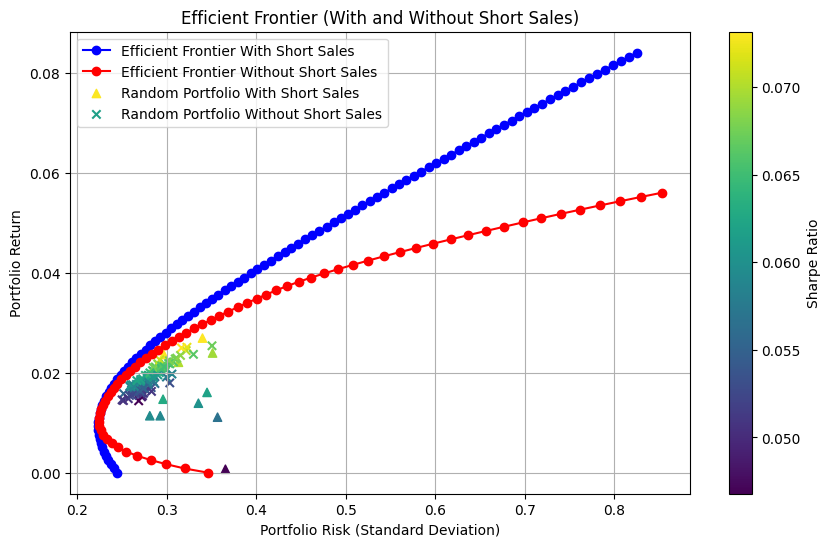

In [85]:
# Efficient Frontier with Daily Data
mu = (daily*21).mean()
Sigma = (daily*21).cov()
target_returns = np.linspace(mu.min()*0.5, mu.max()*1.5, 100)
plt.figure(figsize=(10, 6))

# Calculate Efficient Frontier
def efficient_frontier(mu, Sigma, target_returns, short_sales=True):
    n = len(mu)
    results = []
    for r_t in target_returns:
        constraints = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "eq", "fun": lambda w: w.dot(mu) - r_t}
        ]
        bounds = [(-1, 1)] * n if short_sales else [(0, 1)] * n
        w0 = np.ones(n) / n
        result = minimize(
            lambda w: w.T.dot(Sigma).dot(w),
            w0,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints
        )
        if result.success:
            weights = result.x
            variance = weights.T.dot(Sigma).dot(weights)
            results.append({"Target Return": r_t, "Variance": variance, "Weights": weights})
    return pd.DataFrame(results)

daily_ef_with_short_sales = efficient_frontier(mu, Sigma, target_returns, short_sales=True)
daily_ef_without_short_sales = efficient_frontier(mu, Sigma, target_returns, short_sales=False)

plt.plot(
    daily_ef_with_short_sales['Variance']**0.5, 
    daily_ef_with_short_sales['Target Return'],
    label='Efficient Frontier With Short Sales',
    marker='o', linestyle='-', color='blue'
)

plt.plot(
    daily_ef_without_short_sales['Variance']**0.5, 
    daily_ef_without_short_sales['Target Return'],
    label='Efficient Frontier Without Short Sales',
    marker='o', linestyle='-', color='red'
)

# Generate some Random Portfolios
def random_portfolios(mean_returns, cov_matrix, risk_free_rate, num_portfolios=100, allow_short_sales=True):
    results = pd.DataFrame(columns=["return", "std", "sharpe ratio"])
    num_assets = len(mean_returns)
    for i in range(num_portfolios):
        if allow_short_sales:
            weights = np.random.uniform(-1, 1, num_assets) # weights ~ Unif[-1, 1]
        else:
            weights = np.random.uniform(0, 1, num_assets) # weights ~ Unif[0, 1]
        weights /= np.sum(weights)
        returns = np.sum(mean_returns * weights)
        stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        results.loc[i, "return"] = returns
        results.loc[i, "std"] = stddev
        results.loc[i, "sharpe ratio"] = (returns - risk_free_rate) / stddev
    return results

results_short = random_portfolios(mu, Sigma, monthly_risk_free_rate, allow_short_sales=True)
results_no_short = random_portfolios(mu, Sigma, monthly_risk_free_rate, allow_short_sales=False)

results_short = results_short[results_short["std"] <= results_no_short["std"].max() + 3e-2]

# Draw these Random Portfolios
plt.scatter(
    results_short["std"], 
    results_short["return"], 
    c=results_short["sharpe ratio"],
    marker='^', cmap='viridis', 
    label='Random Portfolio With Short Sales'
)
plt.scatter(
    results_no_short["std"], 
    results_no_short["return"], 
    c=results_no_short["sharpe ratio"],
    marker='x', cmap='viridis', 
    label='Random Portfolio Without Short Sales'
)
plt.colorbar(label='Sharpe Ratio')

plt.title('Efficient Frontier (With and Without Short Sales)')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()

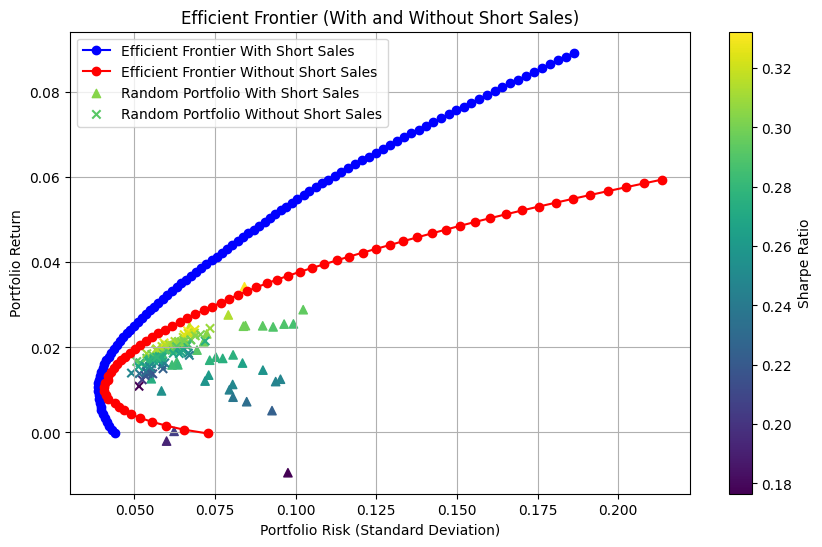

In [86]:
# Efficient Frontier with Monthly Data
mu = monthly.mean()
Sigma = monthly.cov()
target_returns = np.linspace(mu.min()*0.5, mu.max()*1.5, 100)
plt.figure(figsize=(10, 6))

# Calculate Efficient Frontier
def efficient_frontier(mu, Sigma, target_returns, short_sales=True):
    n = len(mu)
    results = []
    for r_t in target_returns:
        constraints = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "eq", "fun": lambda w: w.dot(mu) - r_t}
        ]
        bounds = [(-1, 1)] * n if short_sales else [(0, 1)] * n
        w0 = np.ones(n) / n
        result = minimize(
            lambda w: w.T.dot(Sigma).dot(w),
            w0,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints
        )
        if result.success:
            weights = result.x
            variance = weights.T.dot(Sigma).dot(weights)
            results.append({"Target Return": r_t, "Variance": variance, "Weights": weights})
    return pd.DataFrame(results)

monthly_ef_with_short_sales = efficient_frontier(mu, Sigma, target_returns, short_sales=True)
monthly_ef_without_short_sales = efficient_frontier(mu, Sigma, target_returns, short_sales=False)

plt.plot(
    monthly_ef_with_short_sales['Variance']**0.5, 
    monthly_ef_with_short_sales['Target Return'],
    label='Efficient Frontier With Short Sales',
    marker='o', linestyle='-', color='blue'
)

plt.plot(
    monthly_ef_without_short_sales['Variance']**0.5, 
    monthly_ef_without_short_sales['Target Return'],
    label='Efficient Frontier Without Short Sales',
    marker='o', linestyle='-', color='red'
)

# Generate some Random Portfolios
def random_portfolios(mean_returns, cov_matrix, risk_free_rate, num_portfolios=100, allow_short_sales=True):
    results = pd.DataFrame(columns=["return", "std", "sharpe ratio"])
    num_assets = len(mean_returns)
    for i in range(num_portfolios):
        if allow_short_sales:
            weights = np.random.uniform(-1, 1, num_assets) # weights ~ Unif[-1, 1]
        else:
            weights = np.random.uniform(0, 1, num_assets) # weights ~ Unif[0, 1]
        weights /= np.sum(weights)
        returns = np.sum(mean_returns * weights)
        stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        results.loc[i, "return"] = returns
        results.loc[i, "std"] = stddev
        results.loc[i, "sharpe ratio"] = (returns - risk_free_rate) / stddev
    return results

results_short = random_portfolios(mu, Sigma, monthly_risk_free_rate, allow_short_sales=True)
results_no_short = random_portfolios(mu, Sigma, monthly_risk_free_rate, allow_short_sales=False)

results_short = results_short[results_short["std"] <= results_no_short["std"].max() + 3e-2]

# Draw these Random Portfolios
plt.scatter(
    results_short["std"], 
    results_short["return"], 
    c=results_short["sharpe ratio"],
    marker='^', cmap='viridis', 
    label='Random Portfolio With Short Sales'
)
plt.scatter(
    results_no_short["std"], 
    results_no_short["return"], 
    c=results_no_short["sharpe ratio"],
    marker='x', cmap='viridis', 
    label='Random Portfolio Without Short Sales'
)
plt.colorbar(label='Sharpe Ratio')

plt.title('Efficient Frontier (With and Without Short Sales)')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()

### 2.3.7 Compare the Sharpe Ratios and Find Tangency Portfolio

In [87]:
# Daily Data with Short Sale
fig = go.Figure()

# Plot Assets' Sharpe Ratios
for column in daily.columns:
    fig.add_trace(
        go.Scatter(
            x = [(daily*21)[column].std(), 0],
            y = [(daily*21)[column].mean(), daily_risk_free_rate*21],
            name = column,
            text = f"{column}'s Sharpe Ratio: {((daily*21)[column].mean() - daily_risk_free_rate*21) *100 / (daily*21)[column].std():.3f}%"
        )
    )

# Plot Efficient Frontier
fig.add_trace(
    go.Scatter(
        x = daily_ef_with_short_sales['Variance']**0.5, 
        y = daily_ef_with_short_sales['Target Return'],
        name = "Efficient Frontier With Short Sale",
        marker_color="blue"
    )
)

def portfolio_statistics(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_stddev

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
    return - (p_return - risk_free_rate) / p_stddev

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(-1, 1)] * num_assets
    w0 = np.ones(num_assets) / num_assets
    result = minimize(negative_sharpe_ratio, w0, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Find the Tangency Portfolio
mean_returns = (daily*21).mean()
cov_matrix = (daily*21).cov()
daily_result_with_short = maximize_sharpe_ratio(mean_returns, cov_matrix, daily_risk_free_rate*21)
weights = daily_result_with_short.x
tangency_return, tangency_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
tangency_sharpe_ratio = (tangency_return - daily_risk_free_rate*21) / tangency_stddev

# Plot Tangency Portfolio
fig.add_trace(
    go.Scatter(
        x = [tangency_stddev, 0], 
        y = [tangency_return, daily_risk_free_rate*21],
        name = "Tangency Portfolio With Short Sale",
        text = f"Tangency Portfolio's Sharpe Ratio: {tangency_sharpe_ratio*100:.3f}%",
        marker_color="red"
    )
)

# Plot Risk-free Asset
fig.add_trace(
    go.Scatter(
        x = [0], 
        y = [daily_risk_free_rate*21],
        name = "Risk Free Return",
        text = f"Risk Free Return: {(daily_risk_free_rate*21)*100:.3f}%"
    )
)

fig.update_layout(
    title = "Sharpe Ratio and Tangency Portfolio",
    xaxis = dict(title="Standard Deviation"),
    yaxis = dict(title="Expected Return")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [88]:
# Tangency Portfolio using Daily Data with Short Sale
pd.DataFrame({
    "Stock": daily.columns,
    "Weight": daily_result_with_short.x
})

Stock    Weight
0   AAPL  0.958108
1    PFE -0.617593
2    XOM  0.222130
3    JPM  0.437794
4     GE  0.515268
5     ED  0.683523
6      O -0.635962
7     DD -0.636331
8   NFLX  0.088936
9     KO -0.111372
10  TSLA  0.346086
11  AMZN -0.250588

In [89]:
# Daily Data without Short Sale
fig = go.Figure()

# Plot Assets' Sharpe Ratios
for column in daily.columns:
    fig.add_trace(
        go.Scatter(
            x = [(daily*21)[column].std(), 0],
            y = [(daily*21)[column].mean(), daily_risk_free_rate*21],
            name = column,
            text = f"{column}'s Sharpe Ratio: {((daily*21)[column].mean() - daily_risk_free_rate*21) *100 / (daily*21)[column].std():.3f}%"
        )
    )

# Plot Efficient Frontier
fig.add_trace(
    go.Scatter(
        x = daily_ef_without_short_sales['Variance']**0.5, 
        y = daily_ef_without_short_sales['Target Return'],
        name = "Efficient Frontier Without Short Sale",
        marker_color="blue"
    )
)

def portfolio_statistics(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_stddev

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
    return - (p_return - risk_free_rate) / p_stddev

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0, 1)] * num_assets
    w0 = np.ones(num_assets) / num_assets
    result = minimize(negative_sharpe_ratio, w0, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Find the Tangency Portfolio
mean_returns = (daily*21).mean()
cov_matrix = (daily*21).cov()
daily_result_without_short = maximize_sharpe_ratio(mean_returns, cov_matrix, daily_risk_free_rate*21)
weights = daily_result_without_short.x
tangency_return, tangency_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
tangency_sharpe_ratio = (tangency_return - daily_risk_free_rate*21) / tangency_stddev

# Plot Tangency Portfolio
fig.add_trace(
    go.Scatter(
        x = [tangency_stddev, 0], 
        y = [tangency_return, daily_risk_free_rate*21],
        name = "Tangency Portfolio Without Short Sale",
        text = f"Tangency Portfolio's Sharpe Ratio: {tangency_sharpe_ratio*100:.3f}%",
        marker_color="red"
    )
)

# Plot Risk-free Asset
fig.add_trace(
    go.Scatter(
        x = [0], 
        y = [daily_risk_free_rate*21],
        name = "Risk Free Return",
        text = f"Risk Free Return: {(daily_risk_free_rate*21)*100:.3f}%"
    )
)

fig.update_layout(
    title = "Sharpe Ratio and Tangency Portfolio",
    xaxis = dict(title="Standard Deviation"),
    yaxis = dict(title="Expected Return")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [90]:
# Tangency Portfolio using Daily Data without Short Sale
pd.DataFrame({
    "Stock": daily.columns,
    "Weight": daily_result_without_short.x
})

Stock        Weight
0   AAPL  4.124147e-01
1    PFE  1.492557e-17
2    XOM  1.275658e-02
3    JPM  0.000000e+00
4     GE  2.418294e-01
5     ED  1.013222e-01
6      O  2.364492e-17
7     DD  0.000000e+00
8   NFLX  3.113144e-02
9     KO  0.000000e+00
10  TSLA  2.005457e-01
11  AMZN  1.360589e-17

In [91]:
# Monthly Data with Short Sale
fig = go.Figure()

# Plot Assets' Sharpe Ratios
for column in monthly.columns:
    fig.add_trace(
        go.Scatter(
            x = [monthly[column].std(), 0],
            y = [monthly[column].mean(), monthly_risk_free_rate],
            name = column,
            text = f"{column}'s Sharpe Ratio: {(monthly[column].mean() - monthly_risk_free_rate) *100 / monthly[column].std():.3f}%"
        )
    )

# Plot Efficient Frontier
fig.add_trace(
    go.Scatter(
        x = monthly_ef_with_short_sales['Variance']**0.5, 
        y = monthly_ef_with_short_sales['Target Return'],
        name = "Efficient Frontier With Short Sale",
        marker_color="blue"
    )
)

def portfolio_statistics(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_stddev

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
    return - (p_return - risk_free_rate) / p_stddev

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(-1, 1)] * num_assets
    w0 = np.ones(num_assets) / num_assets
    result = minimize(negative_sharpe_ratio, w0, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Find the Tangency Portfolio
mean_returns = monthly.mean()
cov_matrix = monthly.cov()
monthly_result_with_short = maximize_sharpe_ratio(mean_returns, cov_matrix, monthly_risk_free_rate)
weights = monthly_result_with_short.x
tangency_return, tangency_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
tangency_sharpe_ratio = (tangency_return - monthly_risk_free_rate) / tangency_stddev

# Plot Tangency Portfolio
fig.add_trace(
    go.Scatter(
        x = [tangency_stddev, 0], 
        y = [tangency_return, monthly_risk_free_rate],
        name = "Tangency Portfolio With Short Sale",
        text = f"Tangency Portfolio's Sharpe Ratio: {tangency_sharpe_ratio*100:.3f}%",
        marker_color="red"
    )
)

# Plot Risk-free Asset
fig.add_trace(
    go.Scatter(
        x = [0], 
        y = [monthly_risk_free_rate],
        name = "Risk Free Return",
        text = f"Risk Free Return: {monthly_risk_free_rate*100:.3f}%"
    )
)

fig.update_layout(
    title = "Sharpe Ratio and Tangency Portfolio",
    xaxis = dict(title="Standard Deviation"),
    yaxis = dict(title="Expected Return")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [92]:
# Tangency Portfolio using Monthly Data with Short Sale
pd.DataFrame({
    "Stock": monthly.columns,
    "Weight": monthly_result_with_short.x
})

Stock    Weight
0   AAPL  0.965897
1    PFE -0.439638
2    XOM  0.251521
3    JPM  0.344154
4     GE  0.124470
5     ED  0.972089
6      O -0.986665
7     DD -0.391076
8   NFLX  0.134509
9     KO  0.204648
10  TSLA  0.184997
11  AMZN -0.364904

In [93]:
# Monthly Data without Short Sale
fig = go.Figure()

# Plot Assets' Sharpe Ratios
for column in monthly.columns:
    fig.add_trace(
        go.Scatter(
            x = [monthly[column].std(), 0],
            y = [monthly[column].mean(), monthly_risk_free_rate],
            name = column,
            text = f"{column}'s Sharpe Ratio: {(monthly[column].mean() - monthly_risk_free_rate) *100 / monthly[column].std():.3f}%"
        )
    )

# Plot Efficient Frontier
fig.add_trace(
    go.Scatter(
        x = monthly_ef_without_short_sales['Variance']**0.5, 
        y = monthly_ef_without_short_sales['Target Return'],
        name = "Efficient Frontier With Short Sale",
        marker_color="blue"
    )
)

def portfolio_statistics(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_stddev

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
    return - (p_return - risk_free_rate) / p_stddev

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0, 1)] * num_assets
    w0 = np.ones(num_assets) / num_assets
    result = minimize(negative_sharpe_ratio, w0, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Find the Tangency Portfolio
mean_returns = monthly.mean()
cov_matrix = monthly.cov()
monthly_result_without_short = maximize_sharpe_ratio(mean_returns, cov_matrix, monthly_risk_free_rate)
weights = monthly_result_without_short.x
tangency_return, tangency_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
tangency_sharpe_ratio = (tangency_return - monthly_risk_free_rate) / tangency_stddev

# Plot Tangency Portfolio
fig.add_trace(
    go.Scatter(
        x = [tangency_stddev, 0], 
        y = [tangency_return, monthly_risk_free_rate],
        name = "Tangency Portfolio With Short Sale",
        text = f"Tangency Portfolio's Sharpe Ratio: {tangency_sharpe_ratio*100:.3f}%",
        marker_color="red"
    )
)

# Plot Risk-free Asset
fig.add_trace(
    go.Scatter(
        x = [0], 
        y = [monthly_risk_free_rate],
        name = "Risk Free Return",
        text = f"Risk Free Return: {monthly_risk_free_rate*100:.3f}%"
    )
)

fig.update_layout(
    title = "Sharpe Ratio and Tangency Portfolio",
    xaxis = dict(title="Standard Deviation"),
    yaxis = dict(title="Expected Return")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [94]:
# Tangency Portfolio using Monthly Data without Short Sale
pd.DataFrame({
    "Stock": monthly.columns,
    "Weight": monthly_result_without_short.x
})

Stock        Weight
0   AAPL  4.164408e-01
1    PFE  1.462589e-16
2    XOM  3.605813e-02
3    JPM  4.322464e-02
4     GE  1.788749e-01
5     ED  2.283431e-01
6      O  0.000000e+00
7     DD  0.000000e+00
8   NFLX  1.645434e-02
9     KO  1.311885e-17
10  TSLA  8.060415e-02
11  AMZN  6.410345e-17

## 2.4 Asset Allocation

### 2.4.1 Achieve 1.5% Monthly Expected Return using only Risky Assets

In [95]:
# Construct Efficient Portfolio using Daily Risky Assets
def efficient_portfolio(mu, Sigma, target_return, short_sales=True):
    n = len(mu)
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w.dot(mu) - target_return}
    ]
    bounds = [(-1, 1)] * n if short_sales else [(0, 1)] * n
    w0 = np.ones(n) / n
    result = minimize(
        lambda w: w.T.dot(Sigma).dot(w),
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    return result

mu = (daily*21).mean()
Sigma = (daily*21).cov()

target_return = 1.5e-2

result = efficient_portfolio(mu, Sigma, target_return, False)
daily_weights = result.x
daily_actual_return = daily_weights.dot(mu)
daily_actual_stddev = np.sqrt(daily_weights.T.dot(Sigma.dot(daily_weights)))

fig = go.Figure()

# Plot Target Portfolio
fig.add_trace(
    go.Scatter(
        x = daily_ef_without_short_sales['Variance']**0.5, 
        y = daily_ef_without_short_sales['Target Return'],
        name = "Efficient Frontier Without Short Sale",
        marker_color="blue"
    )
)

fig.add_trace(
    go.Scatter(
        x = [daily_actual_stddev], 
        y = [daily_actual_return],
        name = "Efficient Portfolio",
        marker_color="red"
    )
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [96]:
print("The weights of each assets are as below:")
pd.DataFrame({
    "Stock": daily.columns,
    "Weight": daily_weights
})

The weights of each assets are as below:


Stock    Weight
0   AAPL  0.075457
1    PFE  0.073818
2    XOM  0.099518
3    JPM  0.000000
4     GE  0.030402
5     ED  0.269319
6      O  0.000000
7     DD  0.000000
8   NFLX  0.064685
9     KO  0.269571
10  TSLA  0.041702
11  AMZN  0.075529

In [97]:
# Construct Efficient Portfolio using Monthly Risky Assets
def efficient_portfolio(mu, Sigma, target_return, short_sales=True):
    n = len(mu)
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w.dot(mu) - target_return}
    ]
    bounds = [(-1, 1)] * n if short_sales else [(0, 1)] * n
    w0 = np.ones(n) / n
    result = minimize(
        lambda w: w.T.dot(Sigma).dot(w),
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    return result

mu = monthly.mean()
Sigma = monthly.cov()

target_return = 1.5e-2

result = efficient_portfolio(mu, Sigma, target_return, False)
monthly_weights = result.x
monthly_actual_return = monthly_weights.dot(mu)
monthly_actual_stddev = np.sqrt(monthly_weights.T.dot(Sigma.dot(monthly_weights)))

fig = go.Figure()

# Plot Target Portfolio
fig.add_trace(
    go.Scatter(
        x = monthly_ef_without_short_sales['Variance']**0.5, 
        y = monthly_ef_without_short_sales['Target Return'],
        name = "Efficient Frontier Without Short Sale",
        marker_color="blue"
    )
)

fig.add_trace(
    go.Scatter(
        x = [monthly_actual_stddev], 
        y = [monthly_actual_return],
        name = "Efficient Portfolio",
        marker_color="red"
    )
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [98]:
print("The weights of each assets are as below:")
pd.DataFrame({
    "Stock": monthly.columns,
    "Weight": monthly_weights
})

The weights of each assets are as below:


Stock        Weight
0   AAPL  1.477049e-01
1    PFE  1.040834e-17
2    XOM  7.428084e-02
3    JPM  7.070460e-02
4     GE  1.054590e-02
5     ED  3.449471e-01
6      O  2.580401e-17
7     DD  1.093350e-17
8   NFLX  6.521717e-02
9     KO  2.264052e-01
10  TSLA  8.452409e-03
11  AMZN  5.174189e-02

### 2.4.2 Monthly Risk, VaR, ES for $100,000 Investment

In [99]:
port_returns = (daily*21).dot(daily_weights)
port_risk = port_returns.std()

VaR = np.percentile(port_returns, 5)
ES = port_returns[port_returns <= VaR].mean()

investment = 1e5
actual_VaR = VaR * investment
actual_ES = ES * investment

print(f"Portfolio Risk (Standard Deviation): {port_risk:.4f}") 
print(f"5% VaR (in percentage): {VaR:.4f}") 
print(f"5% VaR (in dollar): ${actual_VaR:.2f}") 
print(f"Expected Shortfall (in percentage): {ES:.4f}") 
print(f"Expected Shortfall (in dollar): ${actual_ES:.2f}")

Portfolio Risk (Standard Deviation): 0.2330
5% VaR (in percentage): -0.3124
5% VaR (in dollar): $-31239.76
Expected Shortfall (in percentage): -0.5513
Expected Shortfall (in dollar): $-55130.55


In [100]:
port_returns = monthly.dot(monthly_weights)
port_risk = port_returns.std()

VaR = np.percentile(port_returns, 5)
ES = port_returns[port_returns <= VaR].mean()

investment = 1e5
actual_VaR = VaR * investment
actual_ES = ES * investment

print(f"Portfolio Risk (Standard Deviation): {port_risk:.4f}") 
print(f"5% VaR (in percentage): {VaR:.4f}") 
print(f"5% VaR (in dollar): ${actual_VaR:.2f}") 
print(f"Expected Shortfall (in percentage): {ES:.4f}") 
print(f"Expected Shortfall (in dollar): ${actual_ES:.2f}")

Portfolio Risk (Standard Deviation): 0.0434
5% VaR (in percentage): -0.0619
5% VaR (in dollar): $-6191.67
Expected Shortfall (in percentage): -0.0894
Expected Shortfall (in dollar): $-8937.18


### 2.4.3 Achieve 1.5% Monthly Expected Return using Risky Assets and T-Bills (risk-free assets)

In [101]:
# Construct Portfolio using Daily Tangency Portfolio and Risk-free Asset

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = daily_ef_without_short_sales['Variance']**0.5, 
        y = daily_ef_without_short_sales['Target Return'],
        name = "Efficient Frontier Without Short Sale",
        marker_color="blue"
    )
)

def portfolio_statistics(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_stddev

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
    return - (p_return - risk_free_rate) / p_stddev

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0, 1)] * num_assets
    w0 = np.ones(num_assets) / num_assets
    result = minimize(negative_sharpe_ratio, w0, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Find the tangency portfolio
mean_returns = (daily*21).mean()
cov_matrix = (daily*21).cov()
daily_result_without_short = maximize_sharpe_ratio(mean_returns, cov_matrix, daily_risk_free_rate*21)
weights = daily_result_without_short.x
tangency_return, tangency_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
tangency_sharpe_ratio = (tangency_return - daily_risk_free_rate*21) / tangency_stddev

fig.add_trace(
    go.Scatter(
        x = [tangency_stddev, 0], 
        y = [tangency_return, daily_risk_free_rate*21],
        name = "Tangency Portfolio Without Short Sale",
        text = f"Tangency Portfolio's Sharpe Ratio: {tangency_sharpe_ratio*100:.3f}%",
        marker_color="red"
    )
)

daily_risky_weight = (target_return - daily_risk_free_rate*21) / (tangency_return - daily_risk_free_rate*21)
port_risk = tangency_stddev * daily_risky_weight

fig.add_trace(
    go.Scatter(
        x = [port_risk, 0], 
        y = [target_return, daily_risk_free_rate*21],
        name = "Target Portfolio",
        text = f"Target Portfolio's Composition: {daily_risky_weight*100:.3f}% of Tangency Portfolio, {(1-daily_risky_weight)*100:.3f}% of Risk-free Portfolio"
    )
)

fig.add_trace(
    go.Scatter(
        x = [0], 
        y = [daily_risk_free_rate*21],
        name = "Risk Free Return",
        text = f"Risk Free Return: {(daily_risk_free_rate*21)*100:.3f}%"
    )
)

fig.update_layout(
    title = "Sharpe Ratio and Tangency Portfolio",
    xaxis = dict(title="Standard Deviation"),
    yaxis = dict(title="Expected Return")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [102]:
# Construct Portfolio using Monthly Tangency Portfolio and Risk-free Asset

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = monthly_ef_without_short_sales['Variance']**0.5, 
        y = monthly_ef_without_short_sales['Target Return'],
        name = "Efficient Frontier Without Short Sale",
        marker_color="blue"
    )
)

def portfolio_statistics(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_stddev

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
    return - (p_return - risk_free_rate) / p_stddev

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0, 1)] * num_assets
    w0 = np.ones(num_assets) / num_assets
    result = minimize(negative_sharpe_ratio, w0, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Find the tangency portfolio
mean_returns = monthly.mean()
cov_matrix = monthly.cov()
monthly_result_without_short = maximize_sharpe_ratio(mean_returns, cov_matrix, monthly_risk_free_rate)
weights = monthly_result_without_short.x
tangency_return, tangency_stddev = portfolio_statistics(weights, mean_returns, cov_matrix)
tangency_sharpe_ratio = (tangency_return - monthly_risk_free_rate) / tangency_stddev

fig.add_trace(
    go.Scatter(
        x = [tangency_stddev, 0], 
        y = [tangency_return, monthly_risk_free_rate],
        name = "Tangency Portfolio Without Short Sale",
        text = f"Tangency Portfolio's Sharpe Ratio: {tangency_sharpe_ratio*100:.3f}%",
        marker_color="red"
    )
)

monthly_risky_weight = (target_return - monthly_risk_free_rate) / (tangency_return - monthly_risk_free_rate)
port_risk = tangency_stddev * monthly_risky_weight

fig.add_trace(
    go.Scatter(
        x = [port_risk, 0], 
        y = [target_return, monthly_risk_free_rate],
        name = "Target Portfolio",
        text = f"Target Portfolio's Composition: {monthly_risky_weight*100:.3f}% of Tangency Portfolio, {(1-monthly_risky_weight)*100:.3f}% of Risk-free Portfolio"
    )
)

fig.add_trace(
    go.Scatter(
        x = [0], 
        y = [monthly_risk_free_rate],
        name = "Risk Free Return",
        text = f"Risk Free Return: {(monthly_risk_free_rate)*100:.3f}%"
    )
)

fig.update_layout(
    title = "Sharpe Ratio and Tangency Portfolio",
    xaxis = dict(title="Standard Deviation"),
    yaxis = dict(title="Expected Return")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

In [103]:
daily_weights = daily_risky_weight*daily_weights
port_returns = daily.dot(daily_weights) + (1-daily_risky_weight) * (daily_risk_free_rate * 21)
port_risk = port_returns.std()

VaR = np.percentile(port_returns, 5)
ES = port_returns[port_returns <= VaR].mean()

investment = 1e5
actual_VaR = VaR * investment
actual_ES = ES * investment

print(f"Portfolio Risk (Standard Deviation): {port_risk:.4f}") 
print(f"5% VaR (in percentage): {VaR:.4f}") 
print(f"5% VaR (in dollar): ${actual_VaR:.2f}") 
print(f"Expected Shortfall (in percentage): {ES:.4f}") 
print(f"Expected Shortfall (in dollar): ${actual_ES:.2f}")

Portfolio Risk (Standard Deviation): 0.0047
5% VaR (in percentage): -0.0053
5% VaR (in dollar): $-532.21
Expected Shortfall (in percentage): -0.0102
Expected Shortfall (in dollar): $-1018.08


In [104]:
port_returns = monthly.dot(monthly_weights)
port_risk = port_returns.std()

VaR = np.percentile(port_returns, 5)
ES = port_returns[port_returns <= VaR].mean()

investment = 1e5
actual_VaR = VaR * investment
actual_ES = ES * investment

print(f"Portfolio Risk (Standard Deviation): {port_risk:.4f}") 
print(f"5% VaR (in percentage): {VaR:.4f}") 
print(f"5% VaR (in dollar): ${actual_VaR:.2f}") 
print(f"Expected Shortfall (in percentage): {ES:.4f}") 
print(f"Expected Shortfall (in dollar): ${actual_ES:.2f}")

Portfolio Risk (Standard Deviation): 0.0434
5% VaR (in percentage): -0.0619
5% VaR (in dollar): $-6191.67
Expected Shortfall (in percentage): -0.0894
Expected Shortfall (in dollar): $-8937.18


## 2.5 PCA

### 2.5.1 Correlation Matrix

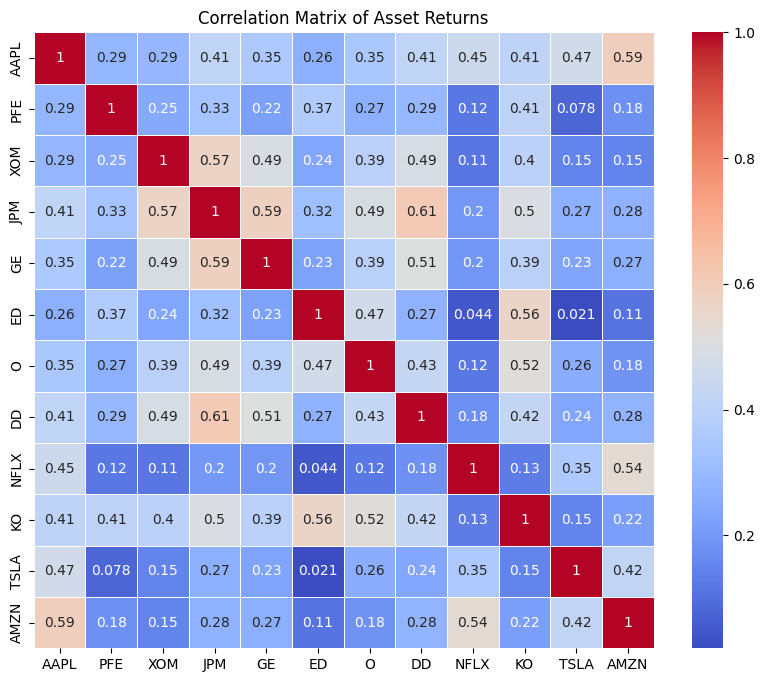

In [105]:
# Correlation Matrix of Daily Data
cov_matrix = daily.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Asset Returns')
plt.show()

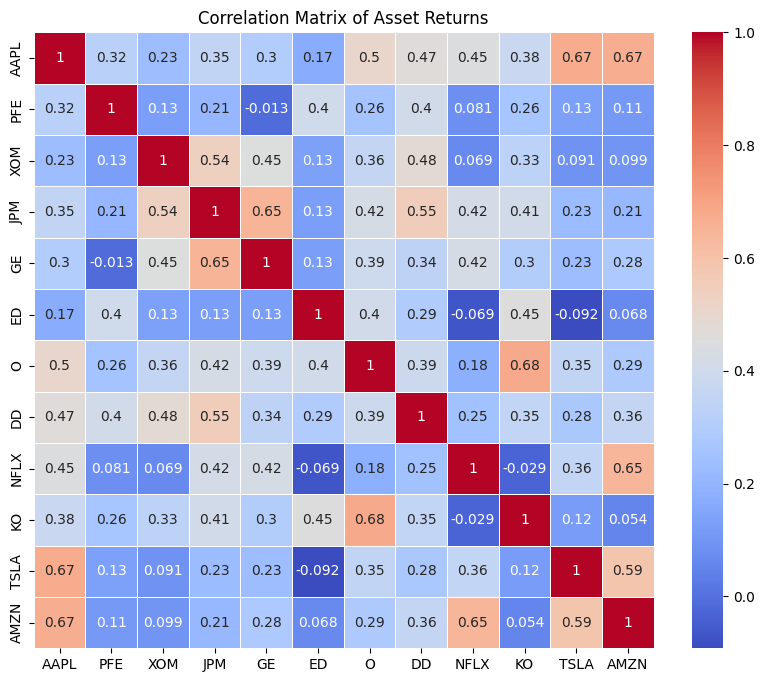

In [106]:
# Correlation Matrix of Monthly Data
cov_matrix = monthly.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Asset Returns')
plt.show()

### 2.5.2 Identify Correlationship

### 2.5.3 Implement PCA

In [107]:
# PCA Results of Daily Data
from sklearn.decomposition import PCA

standard_daily = (daily - daily.mean()) / daily.std()
daily_pca = PCA().fit(standard_daily)

daily_explained_variance = daily_pca.explained_variance_ratio_

print("Explained Variance Ratios:")
print(daily_explained_variance)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = list(range(13)),
        y = np.cumsum(daily_explained_variance),
        name = "Explained Variance Ratios"
    )
)
fig.update_layout(
    title = "Explained Variance by Principal Components",
    xaxis = dict(title="Number of Components"),
    yaxis = dict(title="Cumulative Explained Variance")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

daily_principal_components = daily_pca.components_

print("Principal Components:")
print(daily_principal_components)

Explained Variance Ratios:
[0.38762089 0.14745153 0.09329918 0.06512573 0.05393186 0.04410368
 0.04132594 0.04033816 0.03536092 0.0329246  0.03013361 0.0283839 ]


Principal Components:
[[ 0.32653217  0.23186178  0.29542575  0.36323262  0.31620498  0.24364818
   0.31389051  0.33427779  0.19208587  0.32908161  0.21107667  0.2470599 ]
 [ 0.30929367 -0.15700221 -0.18987421 -0.12324332 -0.06655677 -0.30745687
  -0.18808595 -0.0872657   0.49035589 -0.2340305   0.40901592  0.47326761]
 [ 0.15381693  0.39393553 -0.38217679 -0.27163056 -0.37862051  0.50789098
   0.08211886 -0.27873122  0.11932074  0.277016   -0.07178739  0.13943754]
 [-0.02591453  0.61017943  0.14192606  0.07328928  0.08379457 -0.20343799
  -0.50494736  0.11869951  0.20342216 -0.10386926 -0.46254192  0.13383123]
 [ 0.02642901  0.56083335 -0.05948786  0.03666606 -0.16595995 -0.25821496
   0.01553415  0.0538879  -0.40360702 -0.13551865  0.60388716 -0.19125309]
 [-0.26744816  0.15179055  0.51751146 -0.0279263  -0.13757939 -0.04214875
   0.2423688  -0.45090347  0.50431311 -0.05863459  0.13734849 -0.27827614]
 [-0.31098173  0.1667717  -0.51901576  0.05121013  0.69810593  0.04317542
   0.09901

In [108]:
# PCA Results of Monthly Data
from sklearn.decomposition import PCA

standard_monthly = (monthly - monthly.mean()) / monthly.std()
monthly_pca = PCA().fit(standard_monthly)

monthly_explained_variance = monthly_pca.explained_variance_ratio_

print("Explained Variance Ratios:")
print(monthly_explained_variance)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = list(range(13)),
        y = np.cumsum(monthly_explained_variance),
        name = "Explained Variance Ratios"
    )
)
fig.update_layout(
    title = "Explained Variance by Principal Components",
    xaxis = dict(title="Number of Components"),
    yaxis = dict(title="Cumulative Explained Variance")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

monthly_principal_components = monthly_pca.components_

print("Principal Components:")
print(monthly_principal_components)

Explained Variance Ratios:
[0.3746962  0.16657239 0.1191469  0.07916653 0.06616119 0.04714993
 0.03551212 0.0333355  0.02490482 0.02173895 0.01668293 0.01493254]


Principal Components:
[[ 0.36610685  0.192186    0.25723408  0.34133674  0.29979558  0.17061307
   0.34320855  0.33787903  0.24968047  0.27912303  0.26673493  0.28984838]
 [ 0.21317451 -0.20767827 -0.21980099 -0.0841829   0.01046879 -0.4072525
  -0.19956371 -0.10915294  0.4167445  -0.38356873  0.36954027  0.42539621]
 [-0.27382405 -0.41800083  0.39375603  0.39955567  0.46667037 -0.32562149
  -0.11595227  0.00912838  0.11759982 -0.0950187  -0.20621022 -0.18134877]
 [-0.1084408   0.55995849  0.11772919  0.16054656 -0.10301663  0.05703655
  -0.43576395  0.41247069  0.19533441 -0.40940163 -0.23434531  0.02192913]
 [-0.16440009 -0.05533541 -0.41307322  0.03669711  0.29695758  0.49043633
   0.03452827 -0.25455348  0.48045595  0.02264235 -0.38714357  0.14833216]
 [-0.01952452  0.46534666 -0.38794634  0.35306858  0.06123283 -0.4290338
   0.09511292 -0.2686918   0.14987014  0.20166242  0.12191079 -0.40107263]
 [-0.02165063  0.27952255  0.19359962 -0.11538709  0.49117554  0.29085935
  -0.0834495

### 2.5.4 Factor Analysis

In [109]:
# Factor Analysis for Result of Daily Data
from sklearn.decomposition import FactorAnalysis

daily_fa = FactorAnalysis().fit(standard_daily)

daily_factor_loadings = daily_fa.components_

print("Factor Loadings:")
print(daily_factor_loadings)

daily_explained_variance_factors = np.var(daily_fa.transform(standard_daily), axis=0)
daily_explained_variance_factors_ratio = daily_explained_variance_factors / np.sum(daily_explained_variance_factors)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = list(range(13)),
        y = np.cumsum(daily_explained_variance_factors_ratio),
        name = "Explained Variance Ratios by Factors"
    )
)
fig.update_layout(
    title = "Explained Variance by Factors",
    xaxis = dict(title="Number of Factors"),
    yaxis = dict(title="Cumulative Explained Variance")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

print("Explained Variance Ratios by Factors:")
print(daily_explained_variance_factors_ratio)

Factor Loadings:
[[-6.59622052e-01 -4.48040474e-01 -5.97149697e-01 -7.47459130e-01
  -6.40778738e-01 -4.80288573e-01 -6.29957203e-01 -6.81470383e-01
  -3.75446949e-01 -6.65409924e-01 -4.14836365e-01 -4.92284692e-01]
 [-3.62209503e-01  1.29398691e-01  2.13881803e-01  1.48951005e-01
   8.46414766e-02  2.92329637e-01  2.00266296e-01  1.00931474e-01
  -5.18120986e-01  2.37798782e-01 -4.12879911e-01 -5.26871830e-01]
 [-1.11833509e-01 -2.25656053e-01  2.39457392e-01  1.93366267e-01
   2.51104751e-01 -3.82742691e-01 -1.10841856e-01  1.92777811e-01
  -4.22235106e-02 -2.49199779e-01  5.01369273e-02 -6.92532634e-02]
 [-2.44111027e-03  1.70363948e-01  2.99234331e-02  1.62399094e-02
   1.46111831e-02 -1.21840033e-02 -1.66735237e-01  3.24460469e-02
   6.10317868e-02  3.22353615e-04 -1.68318864e-01  5.14103871e-02]
 [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00

Explained Variance Ratios by Factors:
[0.42033028 0.30978526 0.21165304 0.05823142 0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [110]:
# Factor Analysis for Result of Monthly Data
from sklearn.decomposition import FactorAnalysis

monthly_fa = FactorAnalysis().fit(standard_monthly)

monthly_factor_loadings = monthly_fa.components_

print("Factor Loadings:")
print(monthly_factor_loadings)

monthly_explained_variance_factors = np.var(monthly_fa.transform(standard_monthly), axis=0)
monthly_explained_variance_factors_ratio = monthly_explained_variance_factors / np.sum(monthly_explained_variance_factors)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = list(range(13)),
        y = np.cumsum(monthly_explained_variance_factors_ratio),
        name = "Explained Variance Ratios by Factors"
    )
)
fig.update_layout(
    title = "Explained Variance by Factors",
    xaxis = dict(title="Number of Factors"),
    yaxis = dict(title="Cumulative Explained Variance")
)
fig.update_layout(
    width=1500,
    height=600
)
fig.show()

print("Explained Variance Ratios by Factors:")
print(monthly_explained_variance_factors_ratio)

Factor Loadings:
[[-7.47496538e-01 -3.51965251e-01 -4.82488736e-01 -6.61805861e-01
  -5.83526580e-01 -3.05154897e-01 -6.69917128e-01 -6.50634621e-01
  -5.11688385e-01 -5.32911163e-01 -5.52857881e-01 -6.01380269e-01]
 [ 2.59054175e-01 -1.85140972e-01 -3.24623271e-01 -1.99570967e-01
  -8.85317309e-02 -4.21199607e-01 -2.65424294e-01 -1.52968736e-01
   4.43256032e-01 -4.73864789e-01  4.22875167e-01  5.08731502e-01]
 [-2.33572979e-01 -3.15993356e-01  2.90694702e-01  3.77386905e-01
   4.19313419e-01 -3.24192796e-01 -1.82485232e-01  2.37791341e-02
   2.19087083e-01 -1.92669436e-01 -1.49474732e-01 -8.84446917e-02]
 [ 2.67890757e-02 -3.35857740e-01 -4.90675366e-02 -5.28205085e-02
   1.12236961e-01 -1.07338309e-01  2.18427311e-01 -2.72952346e-01
  -6.92141414e-02  1.89162156e-01  1.20396179e-01 -3.50698988e-02]
 [ 6.38538242e-02 -6.72049793e-03  1.75172738e-01  1.98184795e-04
  -9.87571629e-02 -2.09894265e-01 -2.93049348e-02  1.03412159e-01
  -1.94303328e-01 -2.14983288e-02  1.59281282e-01 -6.99

Explained Variance Ratios by Factors:
[0.32237166 0.26019591 0.21321297 0.12503993 0.07917954 0.
 0.         0.         0.         0.         0.         0.        ]


## 2.6 Risk Management

### 2.6.1 Estimate VaR and ES

In [111]:
# Use Only Month Data
from scipy.stats import norm, t

investment = 1e5
alpha = 5e-2

result = pd.DataFrame(columns=["VaR Normal", "ES Normal", "VaR Nonparametric", "ES Nonparametric"])

for column in monthly.columns:
    data = monthly[column]
    mean = data.mean()
    std = data.std()
    if monthly_best_distribution["Distribution"].loc[column] == "T":
        df = monthly_best_distribution["Degree of Freedom"].loc[column]
        VaR_normal = t.ppf(alpha, df, mean, std)
        ES_normal = mean - std * (t.pdf(t.ppf(alpha, df), df) / alpha) * (df + t.ppf(alpha, df)**2) / (df - 1)
    else:
        VaR_normal = norm.ppf(alpha, mean, std) 
        ES_normal = mean - std * norm.pdf(norm.ppf(alpha)) / alpha

    VaR_nonparametric = np.percentile(data, alpha*100)
    ES_nonparametric = data[data <= VaR_nonparametric].mean()

    result.loc[column, "VaR Normal"] = VaR_normal * investment
    result.loc[column, "ES Normal"] = ES_normal * investment
    result.loc[column, "VaR Nonparametric"] = VaR_nonparametric * investment
    result.loc[column, "ES Nonparametric"] = ES_nonparametric * investment

result

VaR Normal     ES Normal VaR Nonparametric ES Nonparametric
AAPL -10602.974247 -14046.841369     -10885.291805     -12123.56183
PFE  -13467.571702 -17774.881292     -10288.601218    -12112.912704
XOM  -17129.591705 -25260.964366     -12098.189015    -17081.149181
JPM      -12458.63 -17318.208136     -10405.285176    -15363.631367
GE   -21659.072721 -34036.309646     -17075.652335    -21300.066324
ED    -9164.798986 -12452.635018      -6699.484651    -10525.697228
O    -12859.268924 -18158.216626      -8798.772007    -16433.312169
DD   -19716.541816 -28623.845509     -18674.000455     -20144.21376
NFLX -22603.401509 -35198.798362     -11749.912511    -25819.948471
KO    -9520.210912 -13605.762238      -8449.709146    -11796.456249
TSLA -31568.482776 -42861.744411     -21177.450541    -26335.362522
AMZN -15046.543936  -20988.32915     -10572.590016    -14812.513711

### 2.6.2 Identify Highest and Lowest VaR and ES

### 2.6.3 Compute 95% Confidence Intervals for VaR and ES

In [112]:
from sklearn.utils import resample

investment = 1e5
alpha = 5e-2

n_bootstrap = 1000

result = pd.DataFrame(
    columns=[
        "VaR Normal", 
        "ES Normal"
    ]
)

bootstrapped_result = pd.DataFrame(
    columns=[
        "VaR SE", 
        "VaR CI Lower",
        "VaR CI Upper",
        "ES SE",
        "ES CI Lower",
        "ES CI Upper"
    ]
)

for column in monthly.columns:
    data = monthly[column]
    mean = data.mean()
    std = data.std()
    if monthly_best_distribution["Distribution"].loc[column] == "T":
        df = monthly_best_distribution["Degree of Freedom"].loc[column]
        VaR_normal = t.ppf(alpha, df, mean, std)
        ES_normal = mean - std * (t.pdf(t.ppf(alpha, df), df) / alpha) * (df + t.ppf(alpha, df)**2) / (df - 1)
    else:
        VaR_normal = norm.ppf(alpha, mean, std) 
        ES_normal = mean - std * norm.pdf(norm.ppf(alpha)) / alpha
    result.loc[column, "VaR Normal"] = VaR_normal * investment
    result.loc[column, "ES Normal"] = ES_normal * investment
    
    bootstrapped_VaR = []
    bootstrapped_ES = []
    
    for epoch in range(n_bootstrap):
        boot_sample = resample(data)
        boot_mean = boot_sample.mean()
        boot_std = boot_sample.std()
        
        boot_VaR = t.ppf(0.05, df, boot_mean, boot_std)
        boot_ES = boot_mean - boot_std * (t.pdf(t.ppf(alpha, df), df) / alpha) * (df + t.ppf(alpha, df)**2) / (df - 1)
        
        bootstrapped_VaR.append(boot_VaR)
        bootstrapped_ES.append(boot_ES)
    
    bootstrapped_VaR = np.array(bootstrapped_VaR) * investment
    bootstrapped_ES = np.array(bootstrapped_ES) * investment
    
    VaR_t_se = bootstrapped_VaR.std()
    ES_t_se = bootstrapped_ES.std()
    
    VaR_t_ci_lower = np.percentile(bootstrapped_VaR, 2.5)
    VaR_t_ci_upper = np.percentile(bootstrapped_VaR, 97.5)
    
    ES_t_ci_lower = np.percentile(bootstrapped_ES, 2.5)
    ES_t_ci_upper = np.percentile(bootstrapped_ES, 97.5)
    
    bootstrapped_result.loc[column, "VaR SE"] = VaR_t_se
    bootstrapped_result.loc[column, "VaR CI Lower"] = VaR_t_ci_lower
    bootstrapped_result.loc[column, "VaR CI Upper"] = VaR_t_ci_upper
    bootstrapped_result.loc[column, "ES SE"] = ES_t_se
    bootstrapped_result.loc[column, "ES CI Lower"] = ES_t_ci_lower
    bootstrapped_result.loc[column, "ES CI Upper"] = ES_t_ci_upper

print("5% VaR and ES for Each Asset ($100,000 investment over one-month horizon):")
result

5% VaR and ES for Each Asset ($100,000 investment over one-month horizon):


VaR Normal     ES Normal
AAPL -10602.974247 -14046.841369
PFE  -13467.571702 -17774.881292
XOM  -17129.591705 -25260.964366
JPM      -12458.63 -17318.208136
GE   -21659.072721 -34036.309646
ED    -9164.798986 -12452.635018
O    -12859.268924 -18158.216626
DD   -19716.541816 -28623.845509
NFLX -22603.401509 -35198.798362
KO    -9520.210912 -13605.762238
TSLA -31568.482776 -42861.744411
AMZN -15046.543936  -20988.32915

In [113]:
print("Bootstrapped Standard Errors and 95% Confidence Intervals for VaR and ES:")
bootstrapped_result

Bootstrapped Standard Errors and 95% Confidence Intervals for VaR and ES:


VaR SE  VaR CI Lower  VaR CI Upper        ES SE   ES CI Lower  \
AAPL  1480.307291 -14998.689421  -9155.683646  1769.233162 -20980.072595   
PFE   1191.347491 -15743.346813 -11077.913356  1498.248618 -20567.524987   
XOM   2122.442006  -21260.48426 -13149.290413  2864.638254 -30622.298157   
JPM   1710.260272 -15633.165096   -9005.12811  2118.663993 -21261.855942   
GE    2702.010228 -26701.038444 -16187.562599  3894.291684  -41360.65729   
ED    1197.570141 -11457.672561  -6852.999188  1475.791766 -15243.235361   
O     2483.261342 -17731.381248  -8263.825515  3236.535686 -24323.821896   
DD    2394.959091 -24065.621583 -14921.268209  3323.715713 -34726.146659   
NFLX  4538.562789 -31286.537224 -14428.429178  6394.896841 -47627.265989   
KO     1480.56744 -12212.930161  -6575.557887  1887.405415 -17018.531232   
TSLA   3208.21405 -37533.749129  -25135.94128  4040.892642 -50272.839014   
AMZN  1779.578634 -18211.299742 -11577.382067  2290.429025  -25010.11851   

       ES CI Upper  
AAPL -13890.277575  
PFE  -14753.493487  
XOM  -19899.066173  
JPM  -13026.005845  
GE   -26397.133574  
ED    -9580.550961  
O    -12292.144818  
DD   -22111.952582  
NFLX -23559.619872  
KO    -9828.935498  
TSLA -34742.281776  
AMZN -16515.786717

## 2.7 Copulas

See this part in `Copulas.Rmd`.